<a href="https://colab.research.google.com/github/kaedeaki/Data_Science_Internship2023_Data_Glacier/blob/main/Retail_forecasting_notebook_PySpark_2_09122023_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pyspark py4j

In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import pyspark.pandas as ps
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import *

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Convert Excel format to CSV format.

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DG/forecasting_case_study.csv')

In [5]:
df_vis = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DG/forecasting_case_study.csv')

In [6]:
from pyspark.sql import SparkSession

In [7]:

spark = SparkSession.builder.master("local[1]") \
                    .appName('ReadDataExample') \
                    .getOrCreate()
print(spark.sparkContext)
print("Spark App Name : "+ spark.sparkContext.appName)

<SparkContext master=local[1] appName=ReadDataExample>
Spark App Name : ReadDataExample


Read csv.

In [8]:
csv_file_path = "/content/drive/MyDrive/Colab Notebooks/DG/forecasting_case_study.csv"
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [9]:
df.show(5)

+-------+---------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|     date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+---------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1| 2/5/2017|27750|                0%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/12/2017|29023|                0%|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2/19/2017|45630|               17%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/26/2017|26789|                0%|             1|              0|              1|            0.0|         0|    0|     0|        0|
|   SK

In [10]:
display( df )

DataFrame[Product: string, date: string, Sales: int, Price Discount (%): string, In-Store Promo: int, Catalogue Promo: int, Store End Promo: int, Google_Mobility: double, Covid_Flag: int, V_DAY: int, EASTER: int, CHRISTMAS: int]

Check if there are missing values.

In [11]:
from pyspark.sql.functions import col, isnan, when, count

missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns if df.schema[c].dataType != 'date'])
missing_counts.show()

+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      0|   0|    0|                 0|             0|              0|              0|              0|         0|    0|     0|        0|
+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+



**Observation**  
No missng values existing

In [12]:
df.count(), len(df.columns)

(1218, 12)

**Observation**  
1218 observations and 12 columns.

In [13]:
df.printSchema()

root
 |-- Product: string (nullable = true)
 |-- date: string (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: integer (nullable = true)
 |-- Catalogue Promo: integer (nullable = true)
 |-- Store End Promo: integer (nullable = true)
 |-- Google_Mobility: double (nullable = true)
 |-- Covid_Flag: integer (nullable = true)
 |-- V_DAY: integer (nullable = true)
 |-- EASTER: integer (nullable = true)
 |-- CHRISTMAS: integer (nullable = true)



**Observation**   
PySpark does not support "categorical" data type. So, we don't convert the data type for "In-Store Promo", "Catalogue Promo", "Store End Promo", "Covid_Flag", "V_DAY", "EASTER", and "CHRISTMAS".  In general, PySpark uses "string" and "integer" for "categorical" values.  

In [14]:
df.select("Sales", "Google_Mobility")

DataFrame[Sales: int, Google_Mobility: double]

Validate the name of columns. Put _ between word in stead of space.

In [15]:
df = (
    df
    .withColumnRenamed("Price Discount (%)", "Price_Discount")
    .withColumnRenamed("In-Store Promo", "In-Store_Promo")
    .withColumnRenamed("Catalogue Promo", "Catalogue_Promo")
    .withColumnRenamed("Store End Promo", "Store_End_Promo")
)

In [16]:
df.show(5)

+-------+---------+-----+--------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|     date|Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+---------+-----+--------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1| 2/5/2017|27750|            0%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/12/2017|29023|            0%|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2/19/2017|45630|           17%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/26/2017|26789|            0%|             1|              0|              1|            0.0|         0|    0|     0|        0|
|   SKU1| 3/5/2017|41999|         

In [17]:
duplicates = df.groupBy("Product").count().filter(col("count") > 1)
duplicates.show()

+-------+-----+
|Product|count|
+-------+-----+
|   SKU3|  204|
|   SKU4|  204|
|   SKU1|  204|
|   SKU5|  204|
|   SKU6|  198|
|   SKU2|  204|
+-------+-----+



**Observation**  
6products with only SKU6 has 198 counts while others are 204 counts.   

In [18]:
description = df.describe()
description.show()

+-------+-------+---------+------------------+--------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|summary|Product|     date|             Sales|Price_Discount|    In-Store_Promo|    Catalogue_Promo|    Store_End_Promo|    Google_Mobility|         Covid_Flag|               V_DAY|              EASTER|           CHRISTMAS|
+-------+-------+---------+------------------+--------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|  count|   1218|     1218|              1218|          1218|              1218|               1218|               1218|               1218|               1218|                1218|                1218|                1218|
|   mean|   null|     null|30294.678981937603|          null|0.4720853858784893|0.21264367816091953|0.34

In [19]:
df = df.withColumn("Sales", col("Sales").cast(IntegerType()))

In [20]:
df.describe().toPandas()

,summary,Product,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,count,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218
1,mean,None,None,30294.678981937603,None,0.4720853858784893,0.21264367816091953,0.34893267651888343,-2.3774055829228224,0.22660098522167488,0.019704433497536946,0.019704433497536946,0.018883415435139574
2,stddev,None,None,35032.5272965258,None,0.4994252268419534,0.40934571855807333,0.47682841234861867,5.806290981009834,0.4188042296935616,0.13903970926580328,0.13903970926580325,0.13616921612117958
3,min,SKU1,1/12/2020,0,0%,0,0,0,-28.49,0,0,0,0
4,max,SKU6,9/9/2018,288322,9%,1,1,1,3.9,1,1,1,1


Impute SKU6 with 0 since other poducts has 0 during the specific term between 11/22/2020 and 12/27/2020.  
SKU1, SKU3, and SKU6 has high sales amounts so ipute the median of each date of SKU1 and SKU3 each variable.  

In [21]:
from pyspark.sql import Row

data_to_append = [
    Row(Product="SKU6", date="2020-11-22", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-11-29", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-12-06", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-12-13", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-12-20", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0),
    Row(Product="SKU6", date="2020-12-27", Sales=0, Price_Discount= 0, In_Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility= 0, Covid_Flag=1, V_DAY=0, EASTER=0, CHRISTMAS=0)
]

In [22]:
new_data_df = spark.createDataFrame(data_to_append)

df = df.union(new_data_df)

df.show()

+-------+---------+------+--------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|     date| Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+---------+------+--------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1| 2/5/2017| 27750|            0%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/12/2017| 29023|            0%|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2/19/2017| 45630|           17%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/26/2017| 26789|            0%|             1|              0|              1|            0.0|         0|    0|     0|        0|
|   SKU1| 3/5/2017| 41999| 

In [23]:
df.toPandas()

,Product,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2/5/2017,27750,0%,0,0,0,0.0,0,0,0,0
1,SKU1,2/12/2017,29023,0%,1,0,1,0.0,0,1,0,0
2,SKU1,2/19/2017,45630,17%,0,0,0,0.0,0,0,0,0
3,SKU1,2/26/2017,26789,0%,1,0,1,0.0,0,0,0,0
4,SKU1,3/5/2017,41999,17%,0,0,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1219,SKU6,2020-11-29,0,0,0,0,0,0.0,1,0,0,0
1220,SKU6,2020-12-06,0,0,0,0,0,0.0,1,0,0,0
1221,SKU6,2020-12-13,0,0,0,0,0,0.0,1,0,0,0
1222,SKU6,2020-12-20,0,0,0,0,0,0.0,1,0,0,0


In [24]:
#df.write.csv("check.csv", header=True, mode="overwrite")

PySpark is not good at Visualization. So, we convert it to pandas format to plot graphs.

In [25]:
pandas_df = df.toPandas()

In [26]:
pandas_df.describe(include= ['object']).T

,count,unique,top,freq
Product,1224,6,SKU1,204
date,1224,210,2/5/2017,6
Price_Discount,1224,71,0%,231


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme()

In [28]:
from pyspark.sql.functions import when, lit, col

df = df.withColumn("Holiday_Flag", when((col("V_DAY") == 1) | (col("EASTER") == 1) | (col("CHRISTMAS") == 1), lit(1)).otherwise(lit(0)))
df= df.drop("V_DAY", "EASTER", "CHRISTMAS")
df.show()

+-------+---------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
|Product|     date| Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|
+-------+---------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
|   SKU1| 2/5/2017| 27750|            0%|             0|              0|              0|            0.0|         0|           0|
|   SKU1|2/12/2017| 29023|            0%|             1|              0|              1|            0.0|         0|           1|
|   SKU1|2/19/2017| 45630|           17%|             0|              0|              0|            0.0|         0|           0|
|   SKU1|2/26/2017| 26789|            0%|             1|              0|              1|            0.0|         0|           0|
|   SKU1| 3/5/2017| 41999|           17%|             0|              0|              0|         

In [29]:
#df.write.csv("forecasting_case_study2.csv", header=True, mode="overwrite")

In [30]:
df.head()

Row(Product='SKU1', date='2/5/2017', Sales=27750, Price_Discount='0%', In-Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility=0.0, Covid_Flag=0, Holiday_Flag=0)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

<Axes: xlabel='date', ylabel='Sales'>

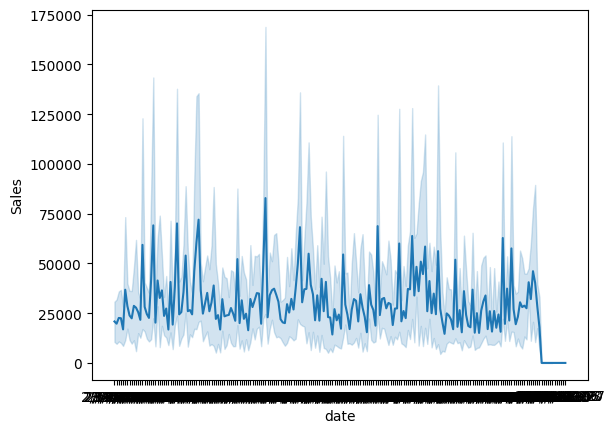

In [31]:
sns.lineplot(x = 'date', y = 'Sales', data=pandas_df)

In [32]:
df.write.option("header", True) \
        .partitionBy("Product") \
        .mode("overwrite") \
        .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast")

In [33]:
df1=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU1")

In [34]:
df2=spark.read.option("header",True) \
           .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU2")

In [35]:
df3=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU3")

In [36]:
df4=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU4")

In [37]:
df5=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU5")

In [38]:
df6=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU6")

In [39]:
#df_all = spark.read.parquet("/content/drive/MyDrive/Colab Notebooks/DG/Forecast")

In [40]:
products = [df1,df2,df3,df4,df5,df6]

In [41]:
for i in range(len(products)):
  print(products[i].head())
  products[i].printSchema()
  products[i].show()
  products[i]= products[i].toPandas()

Row(date='2/5/2017', Sales='27750', Price_Discount='0%', In-Store_Promo='0', Catalogue_Promo='0', Store_End_Promo='0', Google_Mobility='0.0', Covid_Flag='0', Holiday_Flag='0')
root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price_Discount: string (nullable = true)
 |-- In-Store_Promo: string (nullable = true)
 |-- Catalogue_Promo: string (nullable = true)
 |-- Store_End_Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- Holiday_Flag: string (nullable = true)

+---------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
|     date| Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|
+---------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
| 2/5/2017| 27750|            0%|             0|              0

In [42]:
def histplot_boxplot(feature, figsize=(15, 10), bins=None):
    """ Boxplot and histogram combined

    feature: 1-d feature array

    figsize: size of fig (default (9, 8))

    bins: number of bins (default None / auto)

    """
    f2, (ax_box2, ax_his2) = plt.subplots(nrows=2,  # Number of rows of the subplot grid = 2
                                           sharex=True,  # X-axis will be shared among all subplots
                                           gridspec_kw={"height_ratios": (.25, .75)},
                                           figsize=figsize
                                           )  # Creating the 2 subplots

    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='violet')  # Boxplot will be created and a symbol will indicate the mean value of the column

    if bins:
        sns.histplot(x=feature, kde=True, ax=ax_his2, bins=bins, palette="winter")  # For histogram
    else:
        sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram

    ax_his2.axvline(np.mean(feature), color='green', linestyle='--')  # Add mean to the histogram

    ax_his2.axvline(np.median(feature), color='black', linestyle='-')  # Add median to the histogram


In [43]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return 0

In [44]:
#def convert_to_int(value):
    #try:
        #return int(float(value))
    #except ValueError:
        #return np.nan

In [45]:
df1.dtypes

[('date', 'string'),
 ('Sales', 'string'),
 ('Price_Discount', 'string'),
 ('In-Store_Promo', 'string'),
 ('Catalogue_Promo', 'string'),
 ('Store_End_Promo', 'string'),
 ('Google_Mobility', 'string'),
 ('Covid_Flag', 'string'),
 ('Holiday_Flag', 'string')]

In [46]:
#for i in products:
 # print(i.head())
  #df1['Price_Discount']=df1['Price_Discount'].str.rstrip('%').astype(float)/100
  #df1 = df1.withColumn("Price_Discount", col("Price_Discount").cast("int"))
  #print(df1.head())

In [47]:

'''df1['Price_Discount'] = df1['Price_Discount'].apply(convert_to_int,axis=1)'''

"df1['Price_Discount'] = df1['Price_Discount'].apply(convert_to_int,axis=1)"

In [48]:

  #i['Price_Discount']= i['Price_Discount'].str[:-1]

  #i['Price_Discount']= i['Price_Discount'].astype(int)

In [49]:
for i in products:
  print(i.head())

        date  Sales Price_Discount In-Store_Promo Catalogue_Promo  \
0   2/5/2017  27750             0%              0               0   
1  2/12/2017  29023             0%              1               0   
2  2/19/2017  45630            17%              0               0   
3  2/26/2017  26789             0%              1               0   
4   3/5/2017  41999            17%              0               0   

  Store_End_Promo Google_Mobility Covid_Flag Holiday_Flag  
0               0             0.0          0            0  
1               1             0.0          0            1  
2               0             0.0          0            0  
3               1             0.0          0            0  
4               0             0.0          0            0  
        date Sales Price_Discount In-Store_Promo Catalogue_Promo  \
0   2/5/2017  7180            25%              1               0   
1  2/12/2017  7080            25%              0               0   
2  2/19/2017  2753   

In [50]:
df1.head()

Row(date='2/5/2017', Sales='27750', Price_Discount='0%', In-Store_Promo='0', Catalogue_Promo='0', Store_End_Promo='0', Google_Mobility='0.0', Covid_Flag='0', Holiday_Flag='0')

In [51]:
!pip install --upgrade pandas

In [52]:
cols=['Sales','In-Store_Promo','Catalogue_Promo','Store_End_Promo','Google_Mobility','Covid_Flag','Holiday_Flag']
for i in range(len(products)):
  products[i] = ps.DataFrame(products[i])
  products[i]['Price_Discount']=products[i]['Price_Discount'].apply(convert_to_int)
  products[i]['Sales']=products[i]['Sales'].apply(pd.to_numeric)
  products[i]['In-Store_Promo']=products[i]['In-Store_Promo'].apply(pd.to_numeric)
  products[i]['Catalogue_Promo']=products[i]['Catalogue_Promo'].apply(pd.to_numeric)
  products[i]['Store_End_Promo']=products[i]['Store_End_Promo'].apply(pd.to_numeric)
  products[i]['Google_Mobility']=products[i]['Google_Mobility'].apply(pd.to_numeric)
  products[i]['Covid_Flag']=products[i]['Covid_Flag'].apply(pd.to_numeric)
  products[i]['Holiday_Flag']=products[i]['Holiday_Flag'].apply(pd.to_numeric)
  #i['date']=i['date'].apply(pd.to_datetime,axis=1)
  print(products[i].dtypes)

date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag 

In [53]:
for i in products:
  print(i.dtypes)

date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag 

Product : 1


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/

Product : 2


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/

Product : 3


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/

Product : 4


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/

Product : 5


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/

Product : 6


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


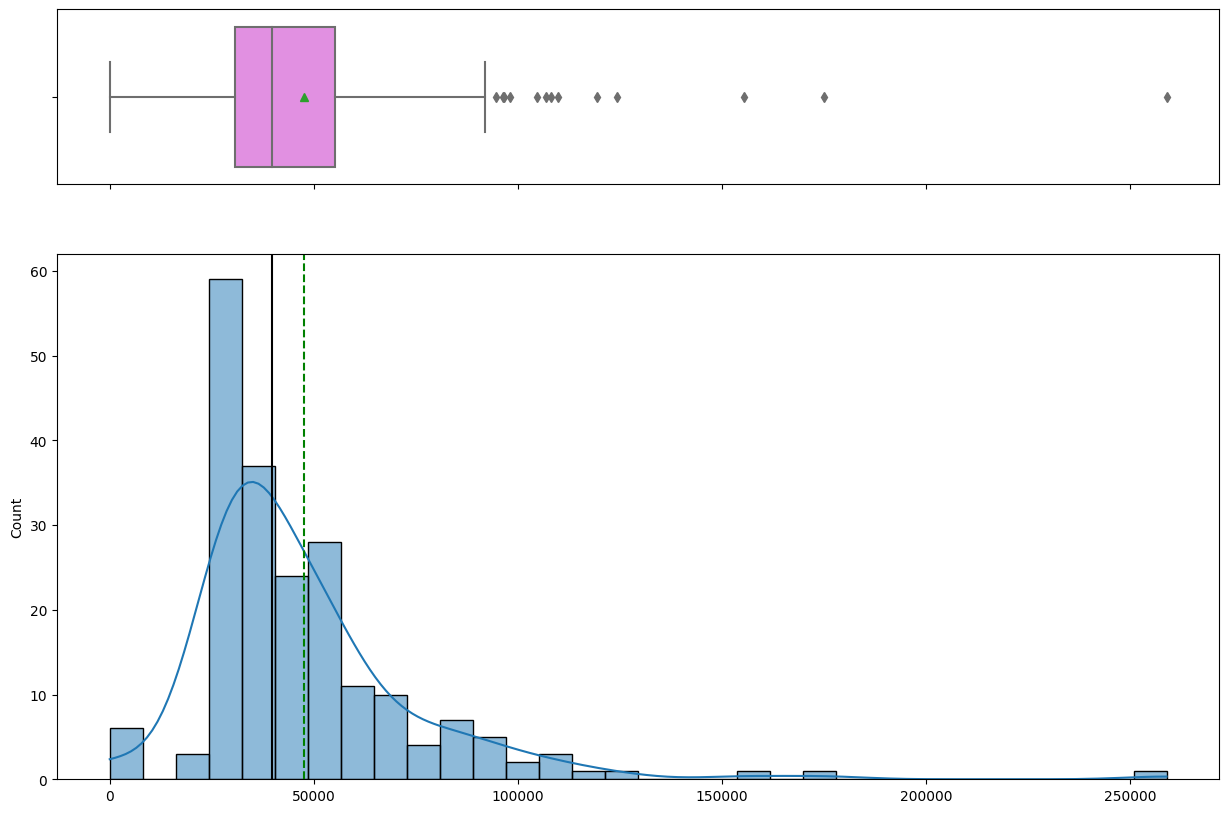

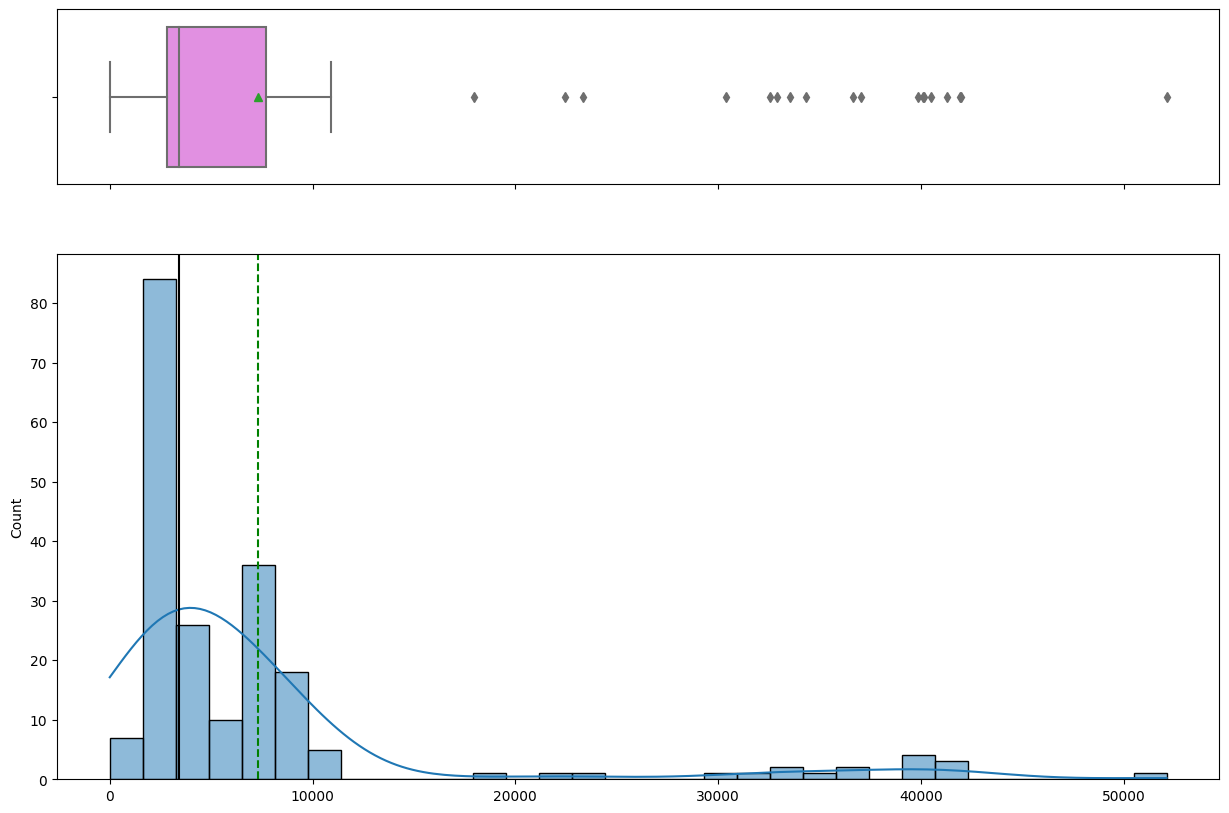

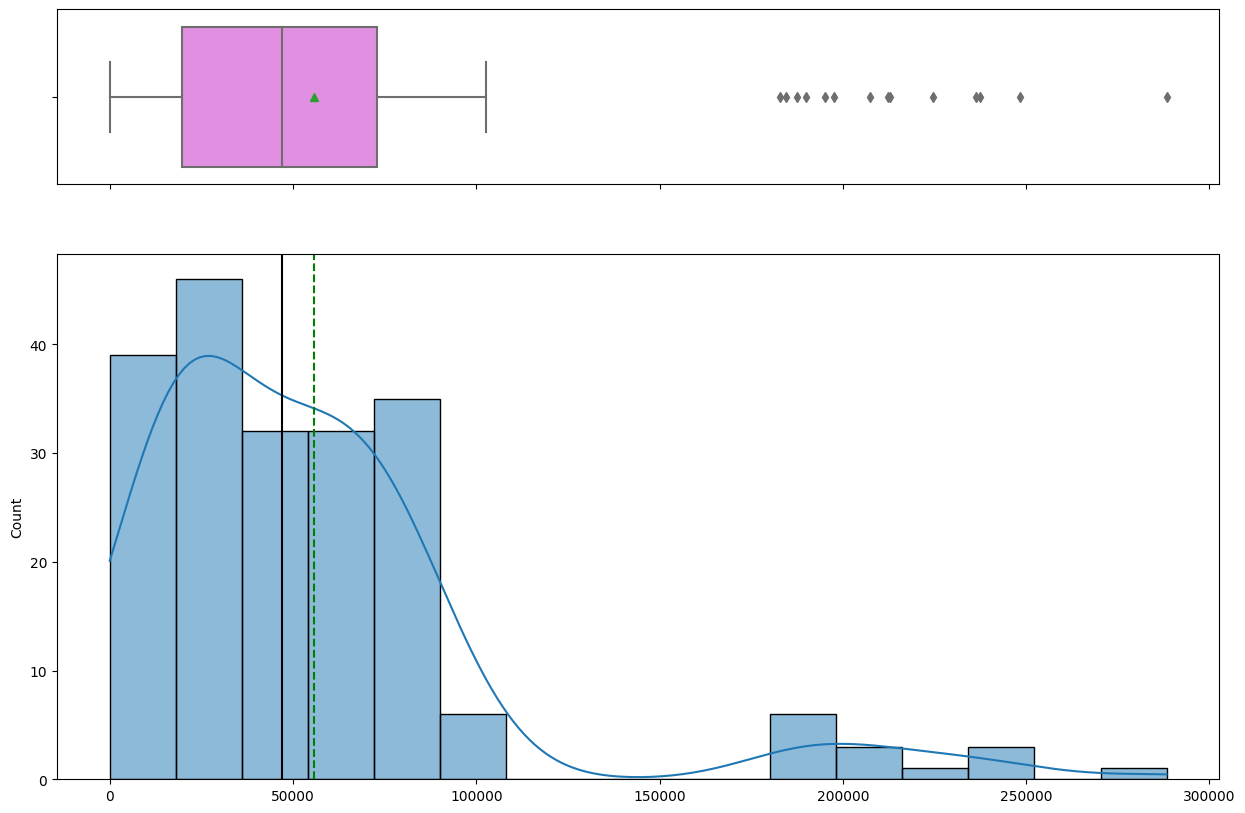

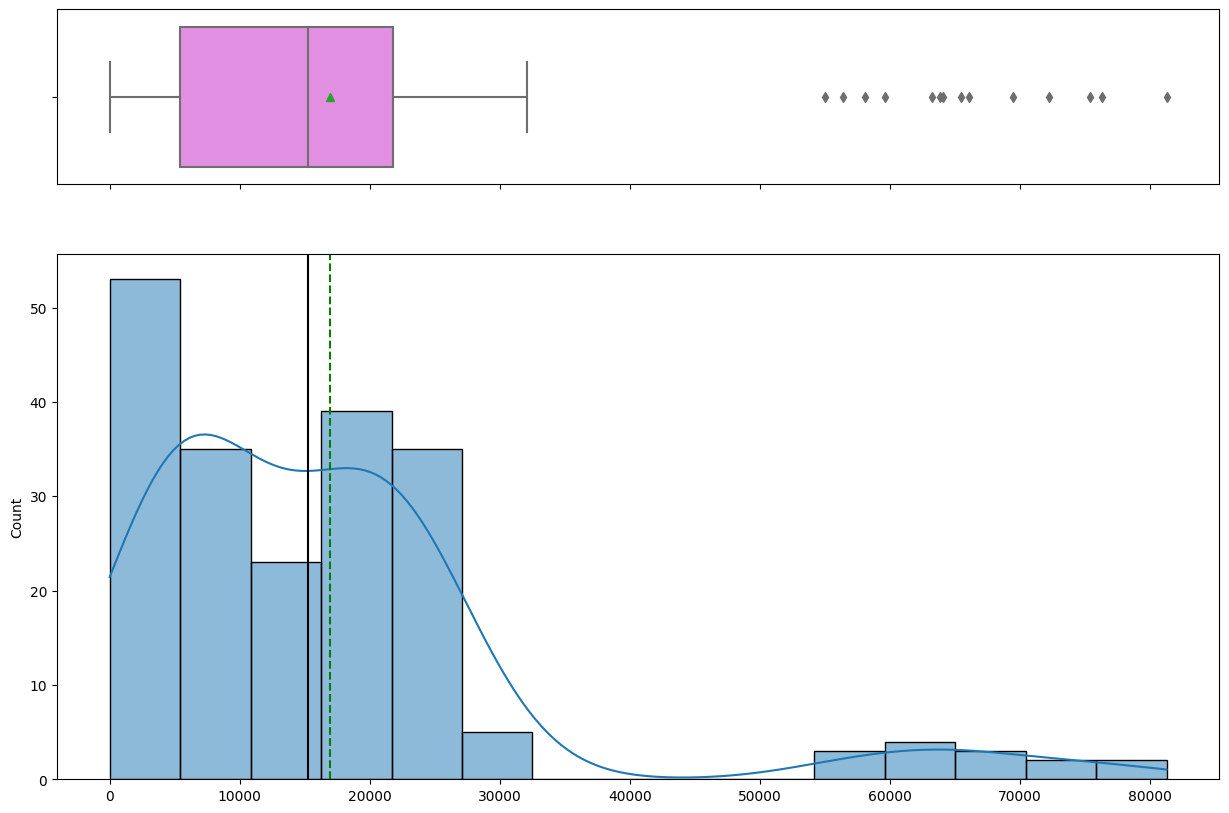

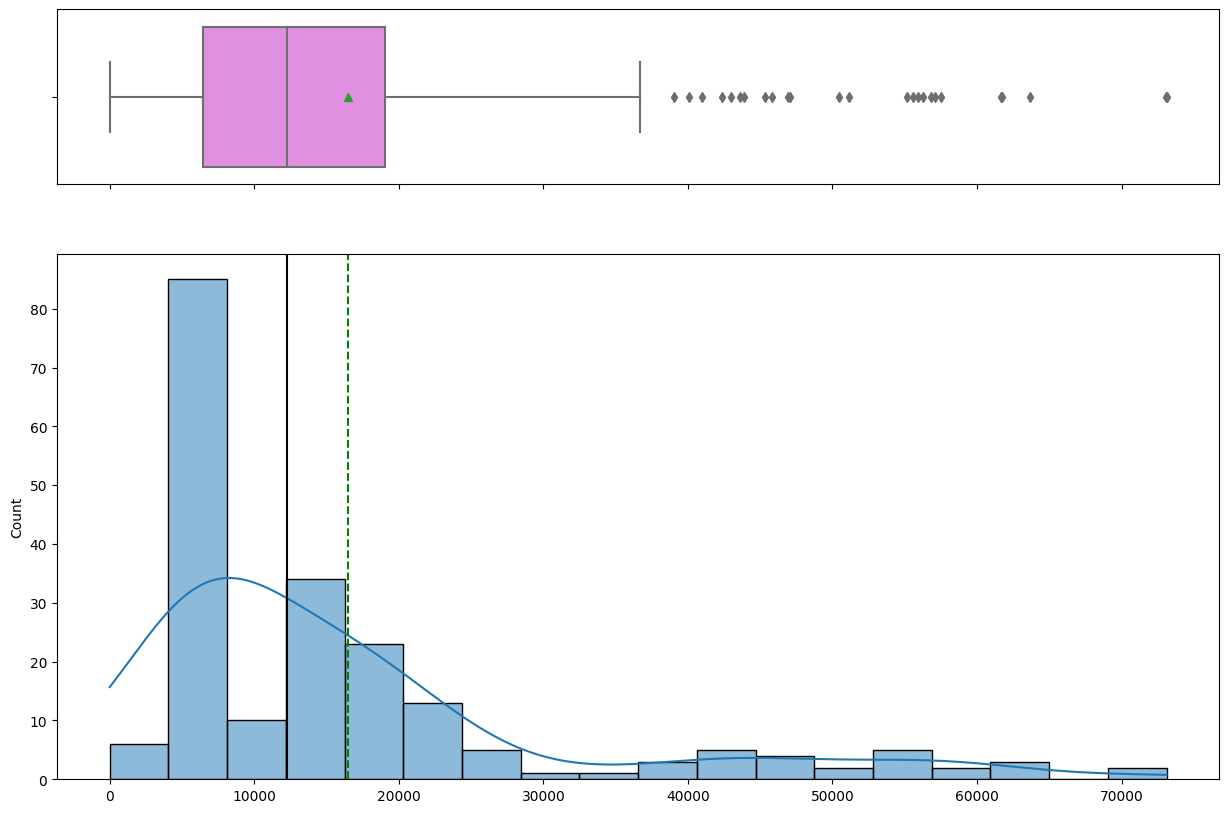

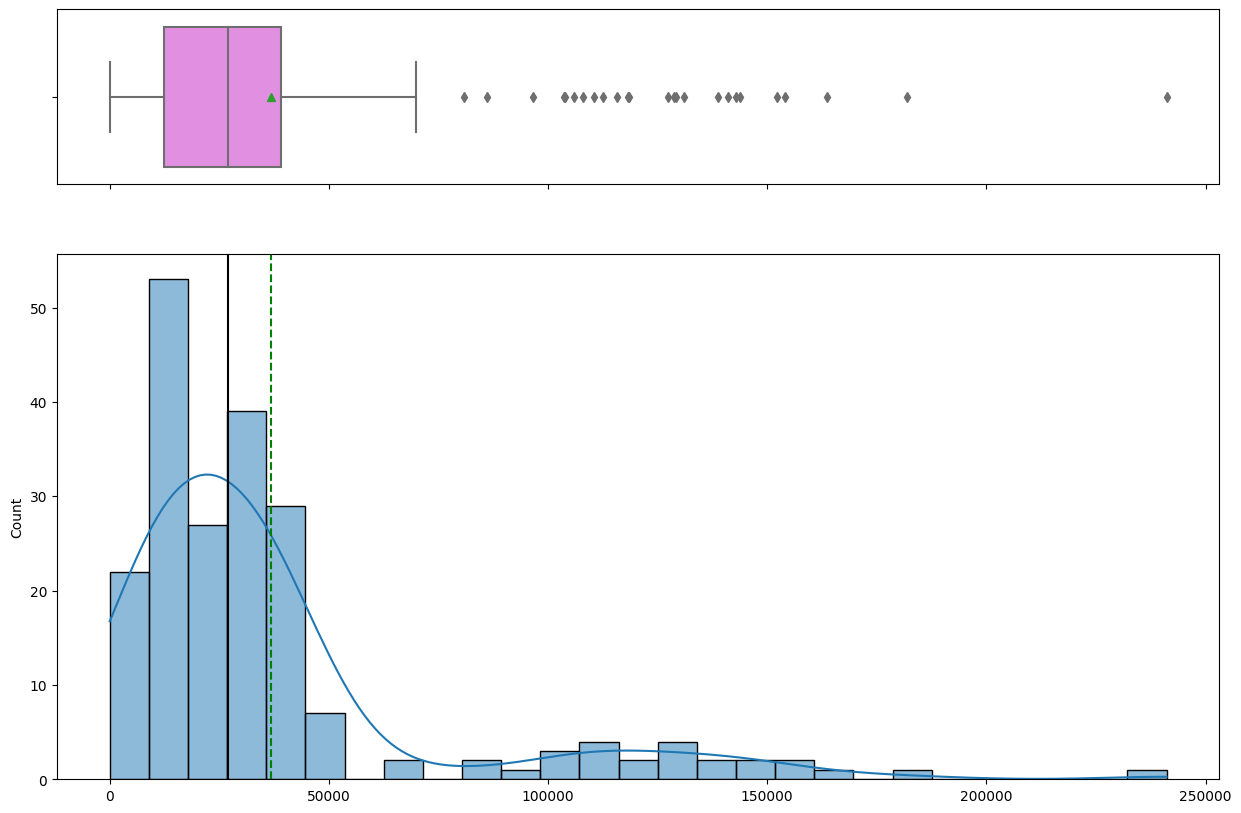

In [54]:
for i in range(len(products)):
  print('Product :',i+1)
  histplot_boxplot(products[i]['Sales'].to_numpy())
  products[i].describe

In [55]:
from pyspark.sql.functions import col, exp

In [56]:
#q_hi  = df1['Sales'].quantile(0.99)
#for i in range(len(products)):

  #quantiles = products[i].approxQuantile('Sales', [0.25, 0.75], 0.01)
  #q1, q3 = quantiles[0], quantiles[1]
  #iqr = q3 - q1

  # Define the upper and lower bounds for outliers
  #lower_bound = q1 - 1.5 * iqr
  #upper_bound = q3 + 1.5 * iqr

  #'''Q1 = np.percentile(products[i]['Sales'], 25, method='midpoint')
  #Q3 = np.percentile(df1['Sales'], 75, method='midpoint')
  #IQR = Q3 - Q1
  #print(IQR)
  #upper= 1.0*IQR #make the range of outliers narrower.
  #df1 = df1[(df1['Sales'] < upper)]'''

In [57]:
cols=['Sales','In-Store_Promo','Catalogue_Promo','Store_End_Promo','Google_Mobility','Covid_Flag','Holiday_Flag']
for i in range(len(products)):
  products[i] = ps.DataFrame(products[i])
  products[i]['Price_Discount']=products[i]['Price_Discount'].apply(convert_to_int)
  products[i]['Sales']=products[i]['Sales'].apply(pd.to_numeric)
  products[i]['In-Store_Promo']=products[i]['In-Store_Promo'].apply(pd.to_numeric)
  products[i]['Catalogue_Promo']=products[i]['Catalogue_Promo'].apply(pd.to_numeric)
  products[i]['Store_End_Promo']=products[i]['Store_End_Promo'].apply(pd.to_numeric)
  products[i]['Google_Mobility']=products[i]['Google_Mobility'].apply(pd.to_numeric)
  products[i]['Covid_Flag']=products[i]['Covid_Flag'].apply(pd.to_numeric)
  products[i]['Holiday_Flag']=products[i]['Holiday_Flag'].apply(pd.to_numeric)
  #i['date']=i['date'].apply(pd.to_datetime,axis=1)
  print(products[i].dtypes)

date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object
date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag 

In [58]:
df1.dtypes

[('date', 'string'),
 ('Sales', 'string'),
 ('Price_Discount', 'string'),
 ('In-Store_Promo', 'string'),
 ('Catalogue_Promo', 'string'),
 ('Store_End_Promo', 'string'),
 ('Google_Mobility', 'string'),
 ('Covid_Flag', 'string'),
 ('Holiday_Flag', 'string')]

In [59]:
#products = [df1,df2,df3,df4,df5,df6]

In [60]:
df1_2 = products[0]
df2_2 = products[1]
df3_2 = products[2]
df4_2 = products[3]
df5_2= products[4]
df6_2 = products[5]

In [61]:
df1_2.dtypes

date                object
Sales                int64
Price_Discount       int64
In-Store_Promo       int64
Catalogue_Promo      int64
Store_End_Promo      int64
Google_Mobility    float64
Covid_Flag           int64
Holiday_Flag         int64
dtype: object

In [62]:
df1_2.to_csv("check1.csv", index = False)
df2_2.to_csv("check2.csv", index = False)
df3_2.to_csv("check3.csv", index = False)
df4_2.to_csv("check4.csv", index = False)
df5_2.to_csv("check5.csv", index = False)
df6_2.to_csv("check6.csv", index = False)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [63]:
df1_2 = pd.read_csv('/content/drive/MyDrive/Data_Glacier/Week11/df1_2.csv')
df2_2 = pd.read_csv('/content/drive/MyDrive/Data_Glacier/Week11/df2_2.csv')
df3_2 = pd.read_csv('/content/drive/MyDrive/Data_Glacier/Week11/df3_2.csv')
df4_2 = pd.read_csv('/content/drive/MyDrive/Data_Glacier/Week11/df4_2.csv')
df5_2 = pd.read_csv('/content/drive/MyDrive/Data_Glacier/Week11/df5_2.csv')
df6_2 = pd.read_csv('/content/drive/MyDrive/Data_Glacier/Week11/df6_2.csv')

In [64]:
Q1 = np.percentile(df1_2['Sales'], 25, method='midpoint')
Q3 = np.percentile(df1_2['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df1_2 = df1_2[(df1_2['Sales'] < upper)]

24606.0


In [65]:
df1_exclude= df1_2.iloc[:, 1:]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


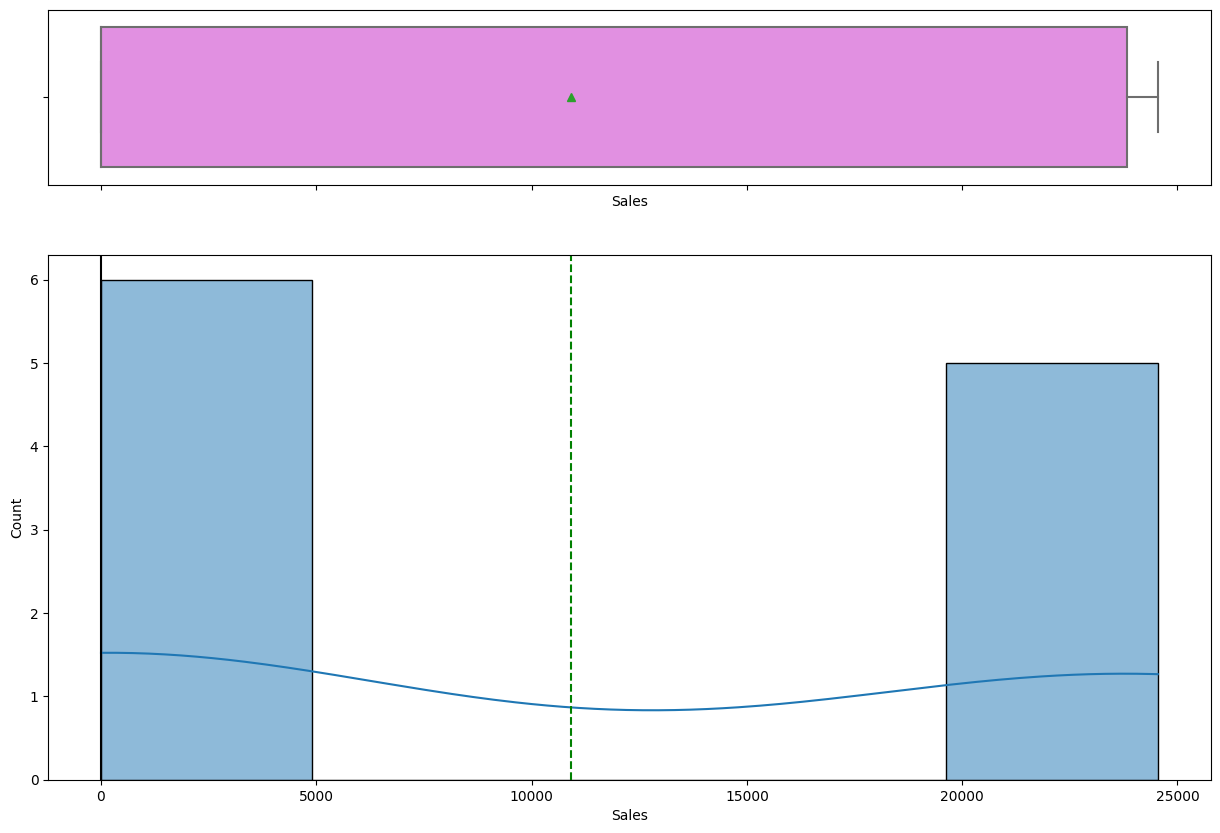

In [66]:
histplot_boxplot(df1_2['Sales'])

In [67]:
df2_2.dtypes

date               object
Sales               int64
Price_Discount      int64
In-Store_Promo      int64
Catalogue_Promo     int64
Store_End_Promo     int64
Google_Mobility     int64
Covid_Flag          int64
Holiday_Flag        int64
dtype: object

In [68]:
Q1 = np.percentile(df2_2['Sales'], 25, method='midpoint')
Q3 = np.percentile(df2_2['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df2_2 = df2_2[(df2_2['Sales'] < upper)]

4891.0


In [69]:
df2_exclude= df2_2.iloc[:, 1:]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


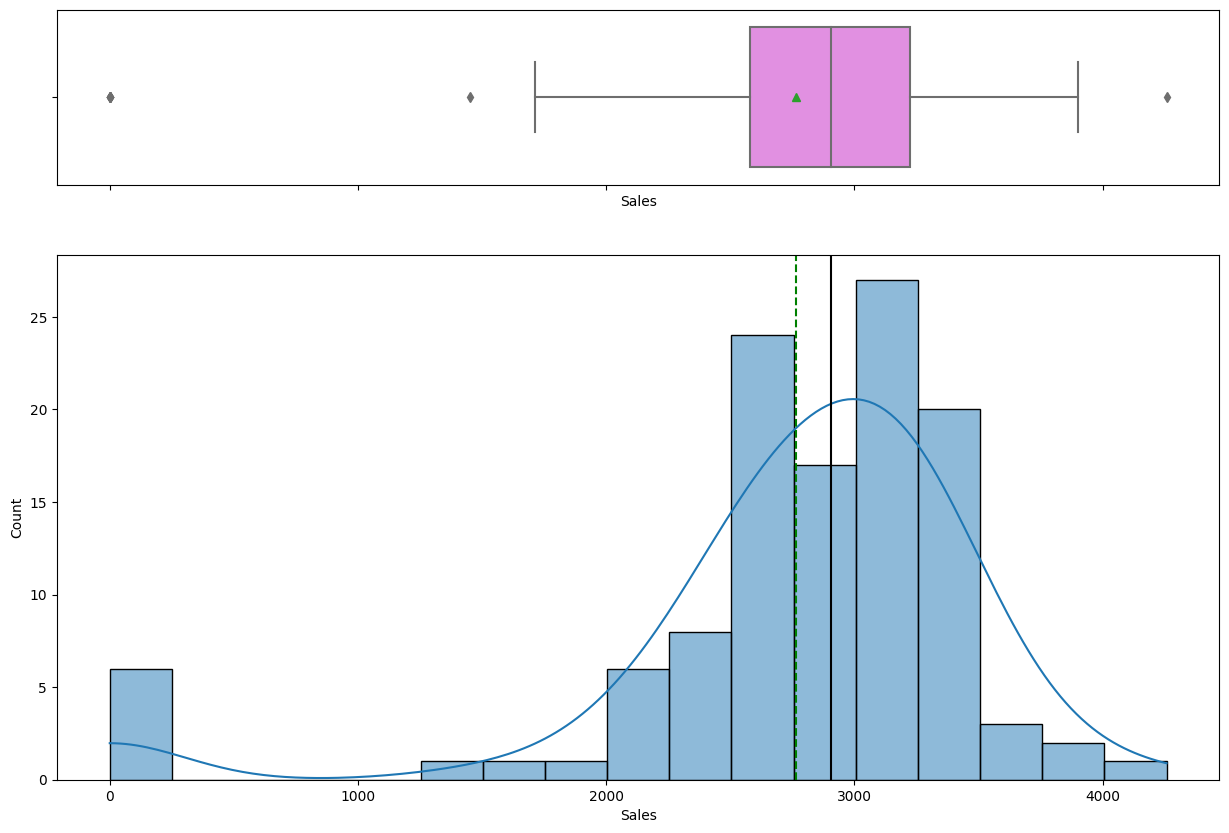

In [70]:
histplot_boxplot(df2_2['Sales'])

In [71]:
df3_2.dtypes

date               object
Sales               int64
Price_Discount      int64
In-Store_Promo      int64
Catalogue_Promo     int64
Store_End_Promo     int64
Google_Mobility     int64
Covid_Flag          int64
Holiday_Flag        int64
dtype: object

In [72]:
Q1 = np.percentile(df3_2['Sales'], 25, method='midpoint')
Q3 = np.percentile(df3_2['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df3_2 = df3_2[(df3_2['Sales'] < upper)]

53491.5


In [73]:
df3_exclude= df3_2.iloc[:, 1:]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


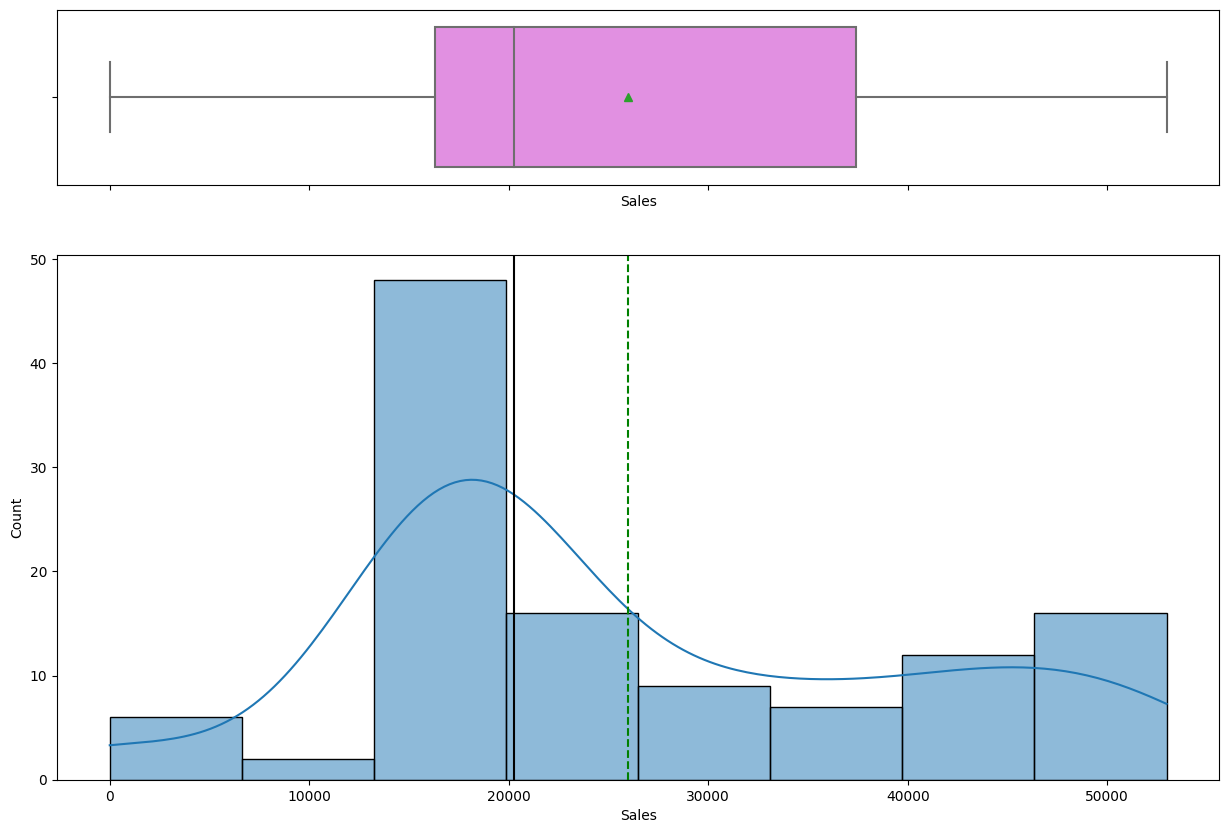

In [74]:
histplot_boxplot(df3_2['Sales'])

In [75]:
df4_2.dtypes

date                object
Sales              float64
Price_Discount     float64
In-Store_Promo     float64
Catalogue_Promo    float64
Store_End_Promo    float64
Google_Mobility    float64
Covid_Flag         float64
Holiday_Flag       float64
dtype: object

In [76]:
Q1 = np.percentile(df4_2['Sales'], 25, method='midpoint')
Q3 = np.percentile(df4_2['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df4_2 = df4_2[(df4_2['Sales'] < upper)]

16423.5


In [77]:
df4_exclude= df4_2.iloc[:, 1:]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


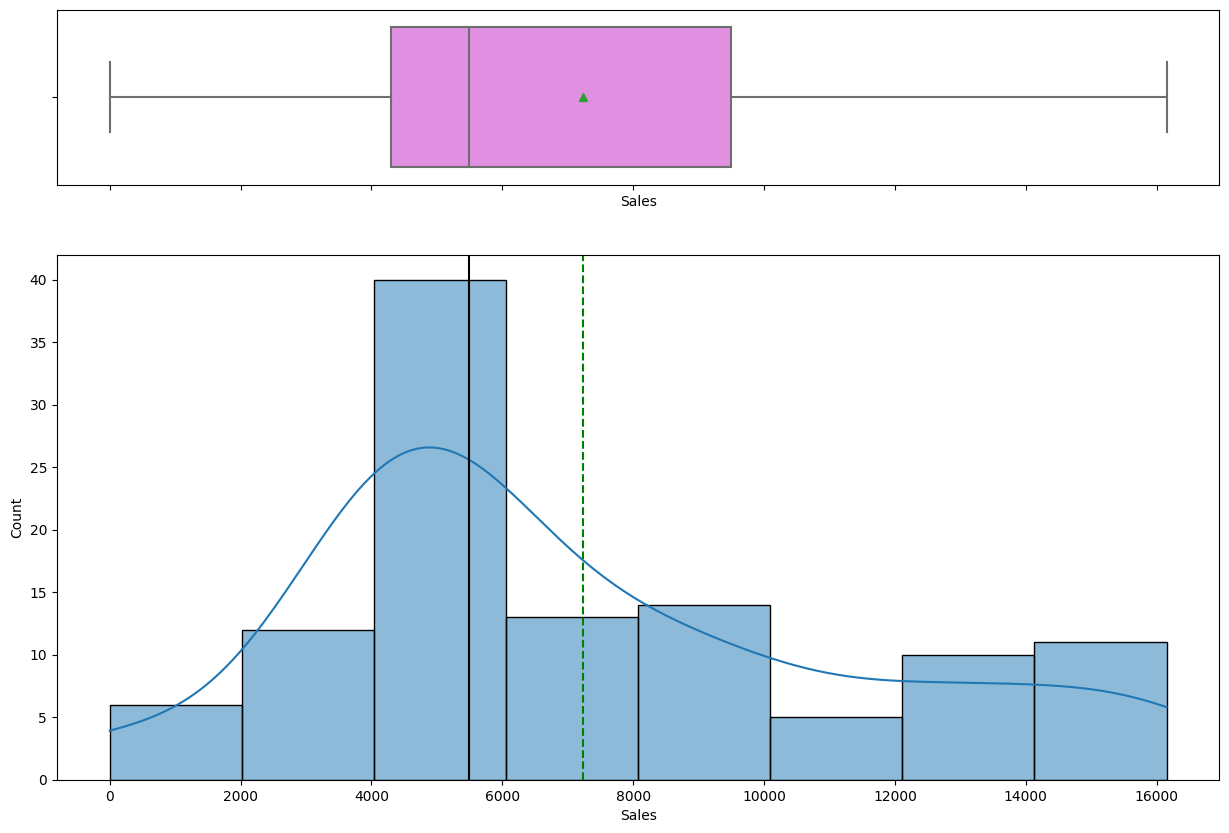

In [78]:
histplot_boxplot(df4_2['Sales'])

In [79]:
df5_2.dtypes

date               object
Sales               int64
Price_Discount      int64
In-Store_Promo      int64
Catalogue_Promo     int64
Store_End_Promo     int64
Google_Mobility     int64
Covid_Flag          int64
Holiday_Flag        int64
dtype: object

In [80]:
Q1 = np.percentile(df5_2['Sales'], 25, method='midpoint')
Q3 = np.percentile(df5_2['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df5_2 = df5_2[(df5_2['Sales'] < upper)]

12673.5


In [81]:
df5_exclude= df5_2.iloc[:, 1:]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


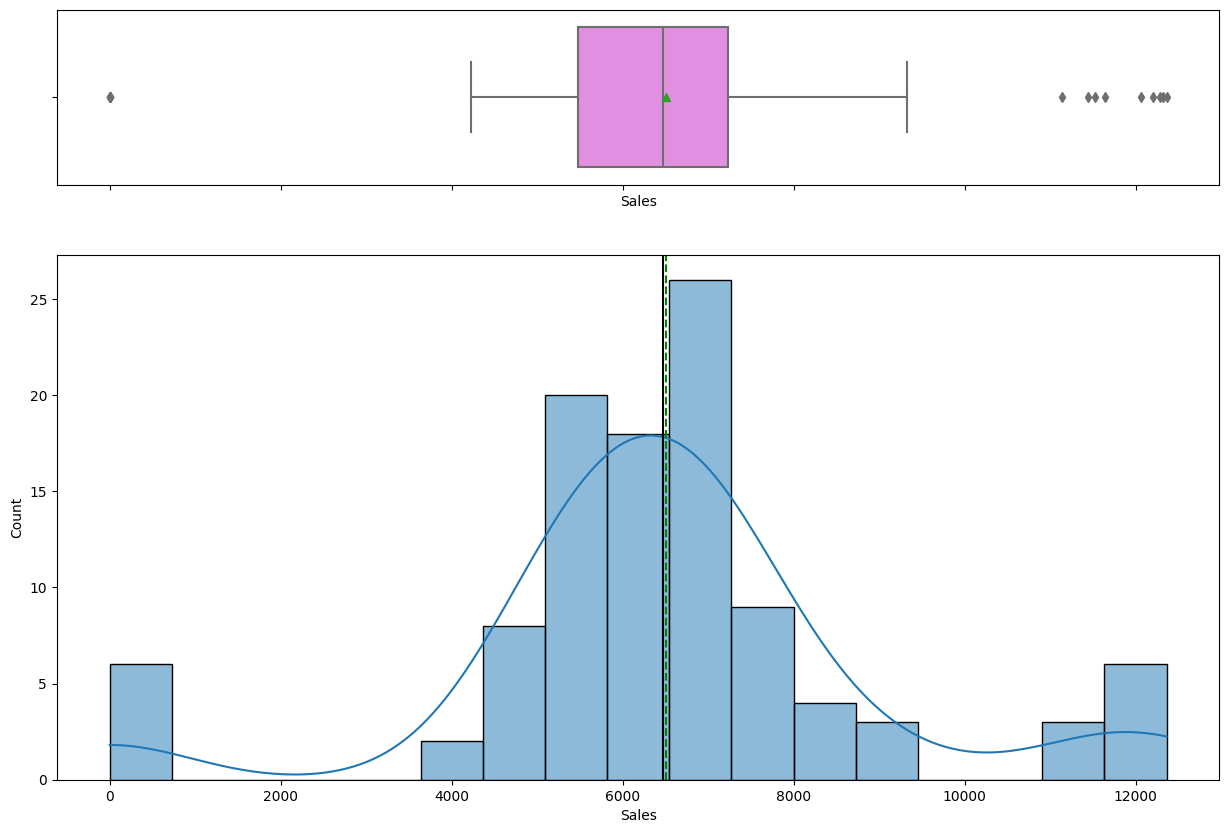

In [82]:
histplot_boxplot(df5_2['Sales'])

In [83]:
df6_2.dtypes

date               object
Sales               int64
Price_Discount      int64
In-Store_Promo      int64
Catalogue_Promo     int64
Store_End_Promo     int64
Google_Mobility     int64
Covid_Flag          int64
Holiday_Flag        int64
dtype: object

In [84]:
Q1 = np.percentile(df6_2['Sales'], 25, method='midpoint')
Q3 = np.percentile(df6_2['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df6_2 = df6_2[(df6_2['Sales'] < upper)]

26869.0


In [85]:
df6_exclude= df6_2.iloc[:, 1:]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
<ipython-input-42-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


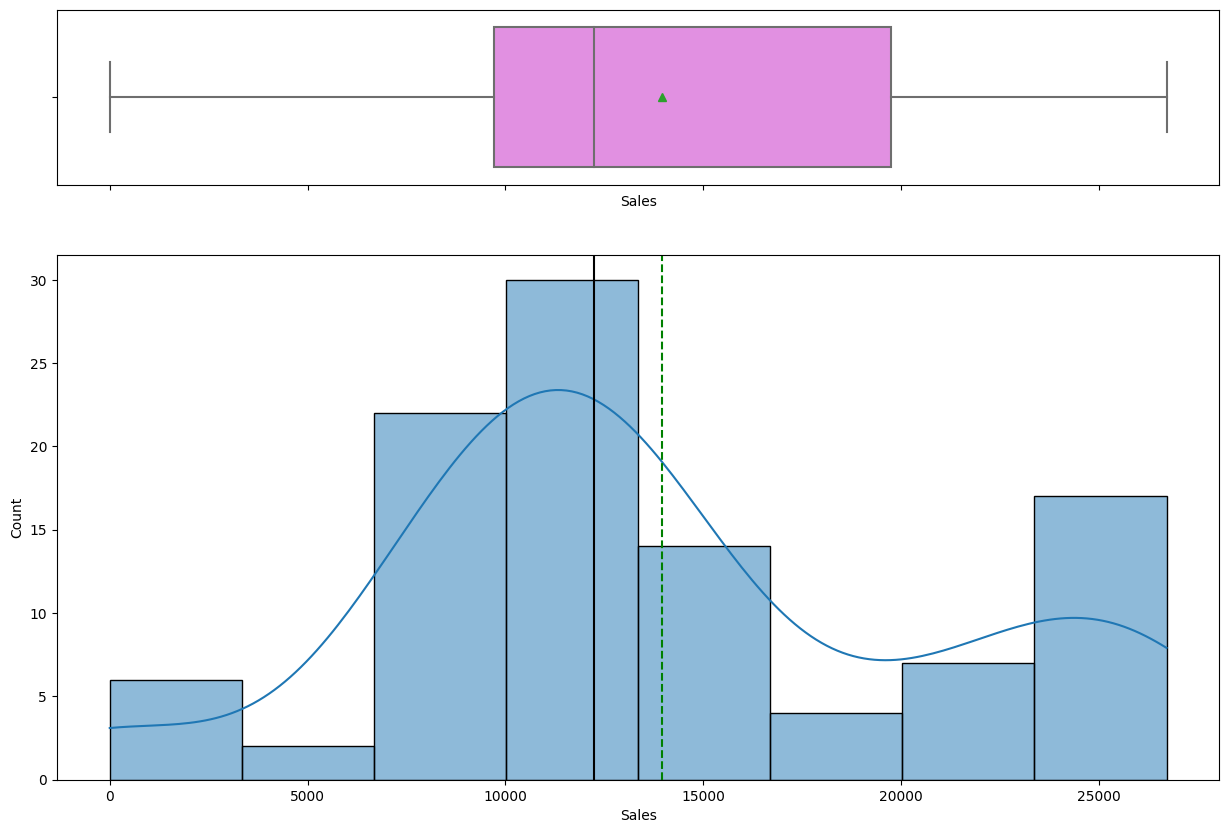

In [86]:
histplot_boxplot(df6_2['Sales'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

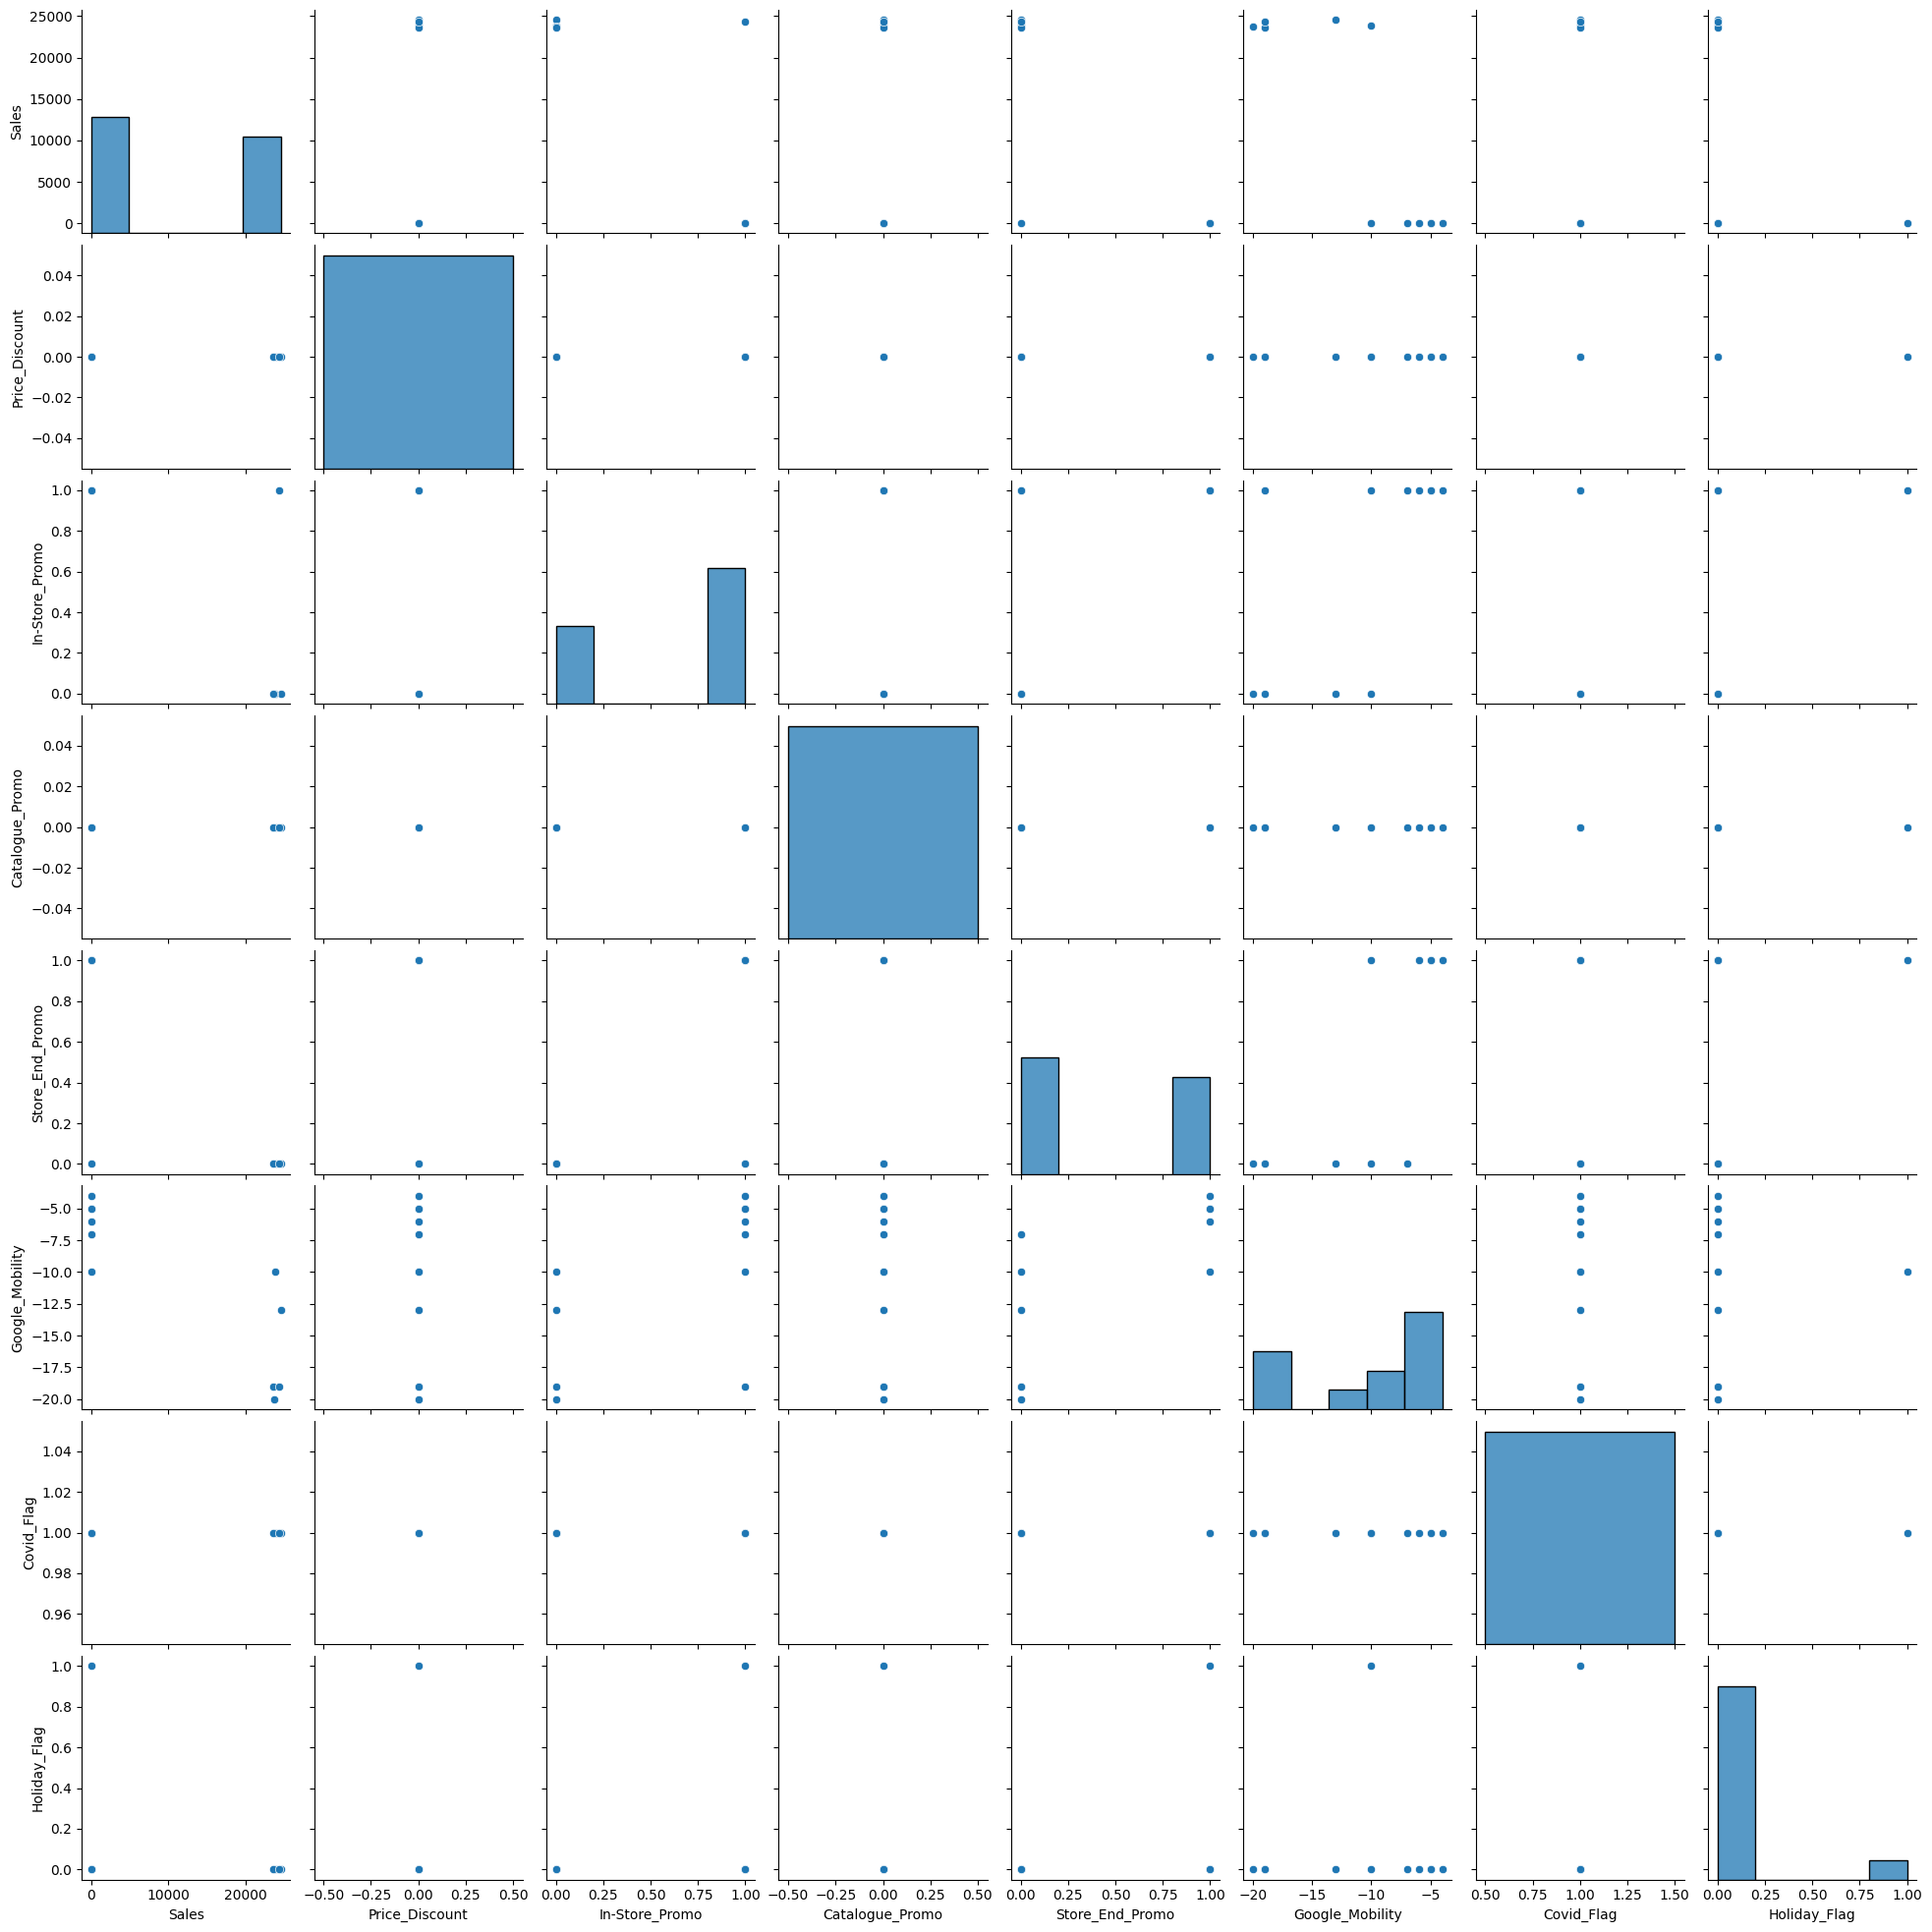

In [87]:
sns.pairplot(data=df1_2.iloc[:, 1:])

In [88]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [89]:
def adf_test(dataset):
     df1test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df1test[0])
     print("2. P-Value : ", df1test[1])
     print("3. Num Of Lags : ", df1test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df1test[3])
     print("5. Critical Values :")
     for key, val in df1test[4].items():
         print("\t",key, ": ", val)
adf_test(df1_2['Sales'])

1. ADF :  -1.0076188092748983
2. P-Value :  0.7504753824440884
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 10
5. Critical Values :
	 1% :  -4.331573
	 5% :  -3.23295
	 10% :  -2.7487


In [90]:
df1_2["Sales"].astype(int)

181    23891
183    24543
184    23744
185    23606
186    24346
198        0
199        0
200        0
201        0
202        0
203        0
Name: Sales, dtype: int64

In [91]:
df1_2.head()

,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag
181,7/26/2020,23891,0,0,0,0,-10,1,0
183,8/9/2020,24543,0,0,0,0,-13,1,0
184,8/16/2020,23744,0,0,0,0,-20,1,0
185,8/23/2020,23606,0,0,0,0,-19,1,0
186,8/30/2020,24346,0,1,0,0,-19,1,0


In [92]:
df1_2['Sales'] = pd.to_numeric(df1_2['Sales'])
df1_2.dtypes

date               object
Sales               int64
Price_Discount      int64
In-Store_Promo      int64
Catalogue_Promo     int64
Store_End_Promo     int64
Google_Mobility     int64
Covid_Flag          int64
Holiday_Flag        int64
dtype: object

In [93]:
el_df=df1_2.set_index('date')

In [94]:
print(el_df)

            Sales  Price_Discount  In-Store_Promo  Catalogue_Promo  \
date                                                                 
7/26/2020   23891               0               0                0   
8/9/2020    24543               0               0                0   
8/16/2020   23744               0               0                0   
8/23/2020   23606               0               0                0   
8/30/2020   24346               0               1                0   
11/22/2020      0               0               1                0   
11/29/2020      0               0               1                0   
12/6/2020       0               0               1                0   
12/13/2020      0               0               1                0   
12/20/2020      0               0               1                0   
12/27/2020      0               0               1                0   

            Store_End_Promo  Google_Mobility  Covid_Flag  Holiday_Flag  
date            

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

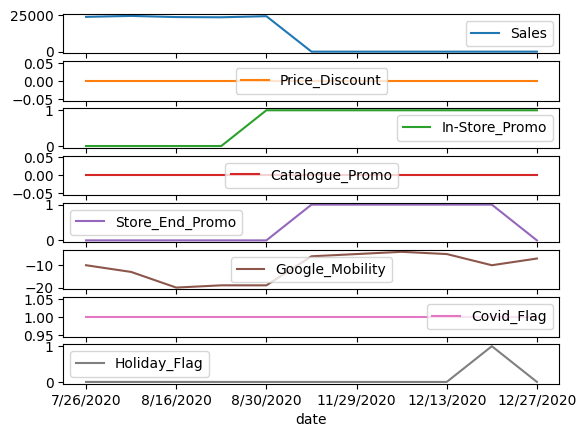

In [95]:
el_df.plot(subplots=True)

In [96]:
#el_df.resample('M').mean()

In [97]:
print ("\nMissing values :  ", df1_2.isnull().any())


Missing values :   date               False
Sales              False
Price_Discount     False
In-Store_Promo     False
Catalogue_Promo    False
Store_End_Promo    False
Google_Mobility    False
Covid_Flag         False
Holiday_Flag       False
dtype: bool


In [98]:
#el_df.resample('M').mean().plot(subplots=True)

In [99]:
#final_df=el_df.resample('M').mean()

In [100]:
#final_df.isnull().any()

In [101]:
#final_df1=final_df.dropna()

#final_df1.isna().sum()

In [102]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     df2test = adfuller(dataset, autolag = 'AIC')
     #df2test = adfuller(dataset.diff()[1:])
     print("1. ADF : ",df2test[0])
     print("2. P-Value : ", df2test[1])
     print("3. Num Of Lags : ", df2test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df2test[3])
     print("5. Critical Values :")
     for key, val in df2test[4].items():
         print("\t",key, ": ", val)
adf_test(df2_2['Sales'])

1. ADF :  -2.4102471662160756
2. P-Value :  0.13886508482595517
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 116
5. Critical Values :
	 1% :  -3.4880216384691867
	 5% :  -2.8867966864160075
	 10% :  -2.5802408234244947


In [103]:
df2_2["Sales"].astype(int)

2      2753
3      3062
5      3124
7      3226
9      3084
       ... 
199       0
200       0
201       0
202       0
203       0
Name: Sales, Length: 117, dtype: int64

In [104]:
df2_2['Sales'] = pd.to_numeric(df2_2['Sales'])
df2_2.dtypes

date               object
Sales               int64
Price_Discount      int64
In-Store_Promo      int64
Catalogue_Promo     int64
Store_End_Promo     int64
Google_Mobility     int64
Covid_Flag          int64
Holiday_Flag        int64
dtype: object

In [105]:
el_df2=df2_2.set_index('date')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

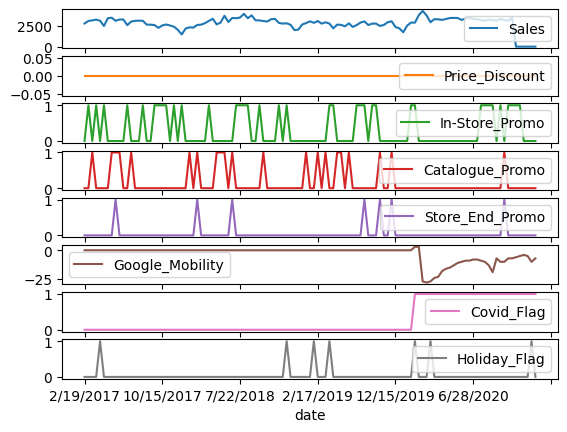

In [106]:
el_df2.plot(subplots=True)

In [107]:
#el_df2.resample('M').mean()

In [108]:
#print ("\nMissing values :  ", df2.isnull().any())

#el_df2.resample('M').mean().plot(subplots=True)

#final_df2=el_df2.resample('M').mean()

In [109]:
#final_df2.isnull().any()

In [110]:
#final_df2=final_df2.dropna()

#final_df2.isna().sum()

In [111]:
#rolling_mean = final_df2['Sales'].rolling(window=12).mean()  # Calculate the 12-month moving average
#detrended_data2 = final_df2['Sales'] - rolling_mean
#adf_test(detrended_data2.dropna())

**Observation**  
P-value became 0.05 that provides the data is stationary.  

In [112]:
def adf_test(dataset):
     df3test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df3test[0])
     print("2. P-Value : ", df3test[1])
     print("3. Num Of Lags : ", df3test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df3test[3])
     print("5. Critical Values :")
     for key, val in df3test[4].items():
         print("\t",key, ": ", val)
adf_test(df3_2['Sales'])

1. ADF :  -2.732775025967565
2. P-Value :  0.06853643571804792
3. Num Of Lags :  5
4. Num Of Observations Used For ADF Regression: 110
5. Critical Values :
	 1% :  -3.4912451337340342
	 5% :  -2.8881954545454547
	 10% :  -2.5809876033057852


In [113]:
df3_2["Sales"].astype(int)

0      39767
1      49090
2      41044
4      13568
5      48230
       ...  
199        0
200        0
201        0
202        0
203        0
Name: Sales, Length: 116, dtype: int64

In [114]:
df3_2['Sales'] = pd.to_numeric(df3_2['Sales'])
df3_2.dtypes


date               object
Sales               int64
Price_Discount      int64
In-Store_Promo      int64
Catalogue_Promo     int64
Store_End_Promo     int64
Google_Mobility     int64
Covid_Flag          int64
Holiday_Flag        int64
dtype: object

In [115]:
el_df3_2=df3_2.set_index('date')


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

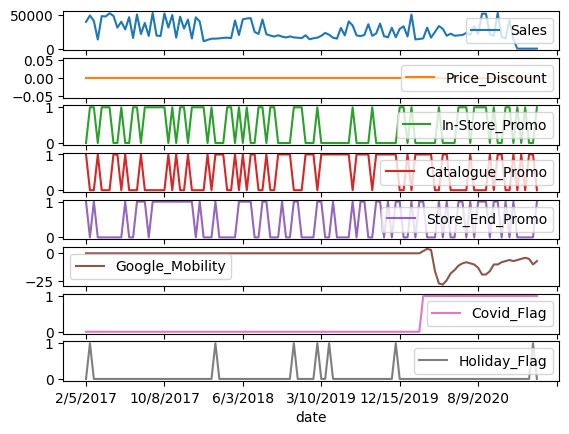

In [116]:
el_df3_2.plot(subplots=True)


In [117]:
#el_df3.resample('M').mean()

In [118]:
#print ("\nMissing values :  ", df3.isnull().any())

#el_df3.resample('M').mean().plot(subplots=True)

#final_df3=el_df.resample('M').mean()

In [119]:
#final_df3.isnull().any()

In [120]:
#final_df3=final_df3.dropna()

#final_df3.isna().sum()

In [121]:
def adf_test(dataset):
     df4test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df4test[0])
     print("2. P-Value : ", df4test[1])
     print("3. Num Of Lags : ", df4test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df4test[3])
     print("5. Critical Values :")
     for key, val in df4test[4].items():
         print("\t",key, ": ", val)
adf_test(df4_2['Sales'])

1. ADF :  -2.9267011767455893
2. P-Value :  0.0423299564919738
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression: 108
5. Critical Values :
	 1% :  -3.4924012594942333
	 5% :  -2.8886968193364835
	 10% :  -2.5812552709190673


In [122]:
df4_2["Sales"].astype(int)

0      12835
1      15705
2      13382
3      15709
4       3729
       ...  
199        0
200        0
201        0
202        0
203        0
Name: Sales, Length: 111, dtype: int64

In [123]:
df4_2['Sales'] = pd.to_numeric(df4_2['Sales'])
df4_2.dtypes

date                object
Sales              float64
Price_Discount     float64
In-Store_Promo     float64
Catalogue_Promo    float64
Store_End_Promo    float64
Google_Mobility    float64
Covid_Flag         float64
Holiday_Flag       float64
dtype: object

In [124]:
el_df4=df4_2.set_index('date')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

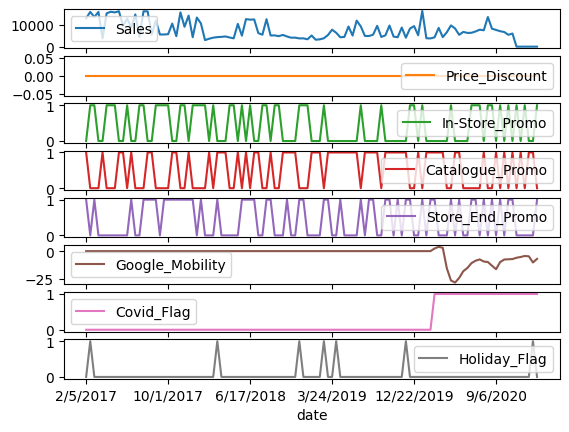

In [125]:
el_df4.plot(subplots=True)

In [126]:
#el_df4.resample('M').mean()

In [127]:
#print ("\nMissing values :  ", df4.isnull().any())

#el_df4.resample('M').mean().plot(subplots=True)

#final_df4=el_df4.resample('M').mean()

In [128]:
#final_df4.isnull().any()

In [129]:
#final_df4=final_df4.dropna()

#final_df4.isna().sum()

In [130]:
def adf_test(dataset):
     df5test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df5test[0])
     print("2. P-Value : ", df5test[1])
     print("3. Num Of Lags : ", df5test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df5test[3])
     print("5. Critical Values :")
     for key, val in df5test[4].items():
         print("\t",key, ": ", val)
adf_test(df5_2['Sales'])

1. ADF :  -5.223830770998545
2. P-Value :  7.858760353568244e-06
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 104
5. Critical Values :
	 1% :  -3.4948504603223145
	 5% :  -2.889758398668639
	 10% :  -2.5818220155325444


In [131]:
df5_2["Sales"].astype(int)

0      5229
1      5748
3      5928
5      5952
6      5994
       ... 
199       0
200       0
201       0
202       0
203       0
Name: Sales, Length: 105, dtype: int64

In [132]:
df5_2['Sales'] = pd.to_numeric(df5_2['Sales'])
df5_2.dtypes

date               object
Sales               int64
Price_Discount      int64
In-Store_Promo      int64
Catalogue_Promo     int64
Store_End_Promo     int64
Google_Mobility     int64
Covid_Flag          int64
Holiday_Flag        int64
dtype: object

In [133]:
el_df5=df5_2.set_index('date')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

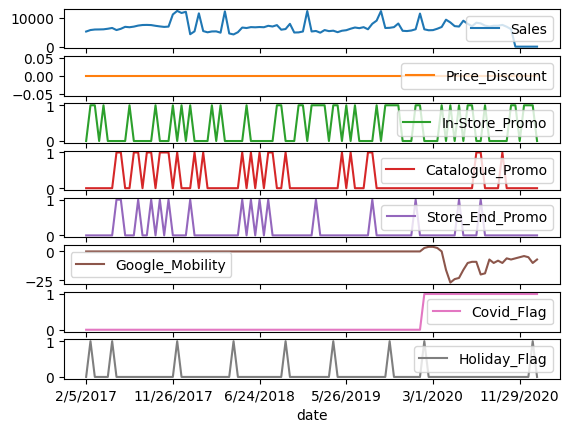

In [134]:
el_df5.plot(subplots=True)

In [135]:
#el_df5.resample('M').mean()

In [136]:
#print ("\nMissing values :  ", df5.isnull().any())

#el_df5.resample('M').mean().plot(subplots=True)

#final_df5=el_df5.resample('M').mean()

In [137]:
#final_df5.isnull().any()

In [138]:
#final_df5=final_df5.dropna()

#final_df5.isna().sum()

In [139]:
def adf_test(dataset):
     df6test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df6test[0])
     print("2. P-Value : ", df6test[1])
     print("3. Num Of Lags : ", df6test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df6test[3])
     print("5. Critical Values :")
     for key, val in df6test[4].items():
         print("\t",key, ": ", val)
adf_test(df6_2['Sales'])


1. ADF :  -5.07203360922023
2. P-Value :  1.5952507284889607e-05
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression: 100
5. Critical Values :
	 1% :  -3.497501033
	 5% :  -2.89090644
	 10% :  -2.5824349


In [140]:
df6_2["Sales"].astype(int)

1      11659
2      12140
4      11666
8      11595
10      9508
       ...  
199        0
200        0
201        0
202        0
203        0
Name: Sales, Length: 102, dtype: int64

In [141]:
df6_2['Sales'] = pd.to_numeric(df6_2['Sales'])
df6_2.dtypes

date               object
Sales               int64
Price_Discount      int64
In-Store_Promo      int64
Catalogue_Promo     int64
Store_End_Promo     int64
Google_Mobility     int64
Covid_Flag          int64
Holiday_Flag        int64
dtype: object

In [142]:
el_df6=df6_2.set_index('date')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

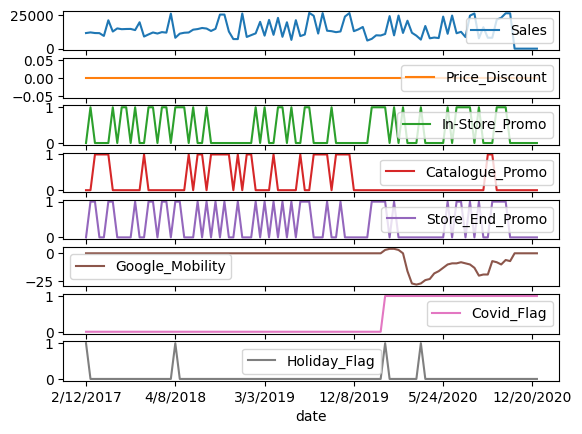

In [143]:
el_df6.plot(subplots=True)

In [144]:
#el_df6.resample('M').mean()

In [145]:
#print ("\nMissing values :  ", df6.isnull().any())

#el_df6.resample('M').mean().plot(subplots=True)

#final_df6=el_df6.resample('M').mean()

In [146]:
#final_df6.isnull().any()

In [147]:
#final_df6=final_df6.dropna()

#final_df6.isna().sum()

In [153]:
df_vis['date'] = pd.to_datetime(df_vis['date'])

df_vis['prev_flag'] = df_vis['Covid_Flag'].shift(1)

start_dates = df_vis[(df_vis['Covid_Flag'] == 1) & (df_vis['prev_flag'] == 0)]

print(start_dates[['date']])

           date
157  2020-02-09
361  2020-02-09
565  2020-02-09
769  2020-02-09
973  2020-02-09
1177 2020-02-09


**Observation**  
Covid Flag started from February 09, 2020.  

In [154]:
! pip install plotly

In [ ]:
#df_vis.toPandas()

In [156]:
import plotly.express as px

#pandas_df = df_vis.toPandas()

fig = px.line(df_vis, x='date', y='Google_Mobility', title='Google_Mobility')

min_desired_value = -30
max_desired_value = 10
fig.update_yaxes(range=[min_desired_value, max_desired_value])

fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



**Observation**  
-Google Mobility is realted Covid19. This is because the line is flat until February 2, 2020 above the plot. The flat line means there are no activities and no exisiting record.   
-After February 9, 2020, it started fluctuating and keep changing. According to the variable Covid Flag, it started recorded as 1 after February 9, 2020. The timing between Google Mobility and Covid Flag is exactly coinside.  
-Google Mobility data tracks travel patterns in detail, such as how often people go to public places and how much time they spend commuting or shopping. This will allow us to assess the risk of spread of infection and predict the spread of infection in a particular region or city.  

**To analyze the data pre-Covid and post-Covid, we divide the data to 2.**

In [161]:
from pyspark.sql.functions import col

before_date = df.filter(col("date") < "2020-02-09")

after_date = df.filter(col("date") >= "2020-02-09")

before_date.show()
after_date.show()

+-------+----------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
|Product|      date| Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|
+-------+----------+------+--------------+--------------+---------------+---------------+---------------+----------+------------+
|   SKU1|  2/5/2017| 27750|            0%|             0|              0|              0|            0.0|         0|           0|
|   SKU1| 2/12/2017| 29023|            0%|             1|              0|              1|            0.0|         0|           1|
|   SKU1| 2/19/2017| 45630|           17%|             0|              0|              0|            0.0|         0|           0|
|   SKU1| 2/26/2017| 26789|            0%|             1|              0|              1|            0.0|         0|           0|
|   SKU1| 10/1/2017| 96610|           44%|             0|              0|              0| 

In [162]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

before_date = before_date.withColumn('Sales', col('Sales').cast(FloatType()))

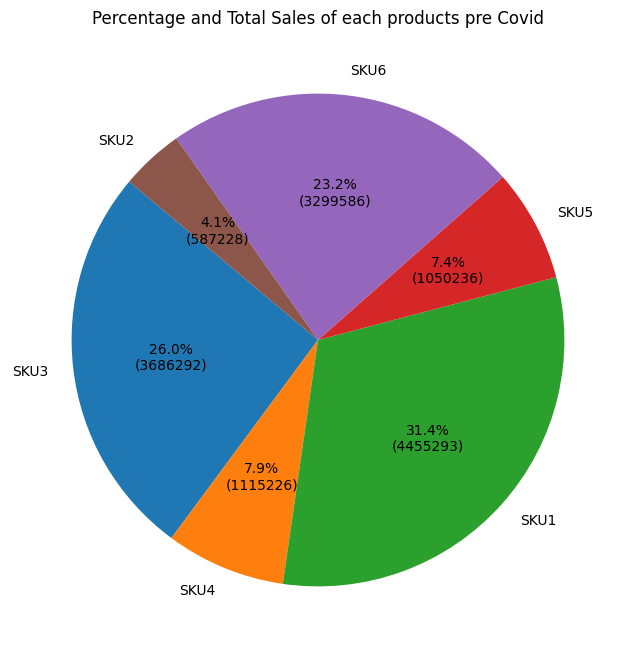

In [163]:
from pyspark.sql import functions as F

before_date = before_date.withColumn('Sales', F.when(F.col('Sales').isNull(), 0).otherwise(F.col('Sales')))

product_sales = before_date.groupBy('Product').agg(F.sum('Sales').alias('TotalSales'))

product_sales_pd = product_sales.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(product_sales_pd['TotalSales'], labels=product_sales_pd['Product'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(product_sales_pd['TotalSales']) / 100), startangle=140)

plt.title('Percentage and Total Sales of each products pre Covid')

plt.show()

In [164]:
from pyspark.sql.functions import col

null_columns = [col(c).alias(c) for c in after_date.columns]

after_date.select(null_columns).filter(after_date['Sales'].isNull()).show()

+-------+----+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+
|Product|date|Sales|Price_Discount|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|Holiday_Flag|
+-------+----+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+
+-------+----+-----+--------------+--------------+---------------+---------------+---------------+----------+------------+



In [165]:
after_date1 = after_date.toPandas()
after_date1.isnull().any()

Product            False
date               False
Sales              False
Price_Discount     False
In-Store_Promo     False
Catalogue_Promo    False
Store_End_Promo    False
Google_Mobility    False
Covid_Flag         False
Holiday_Flag       False
dtype: bool

In [166]:
print(after_date1[after_date1['Sales'].isnull()])

Empty DataFrame
Columns: [Product, date, Sales, Price_Discount, In-Store_Promo, Catalogue_Promo, Store_End_Promo, Google_Mobility, Covid_Flag, Holiday_Flag]
Index: []


In [167]:
after_date = after_date[after_date['Sales'] != 0]

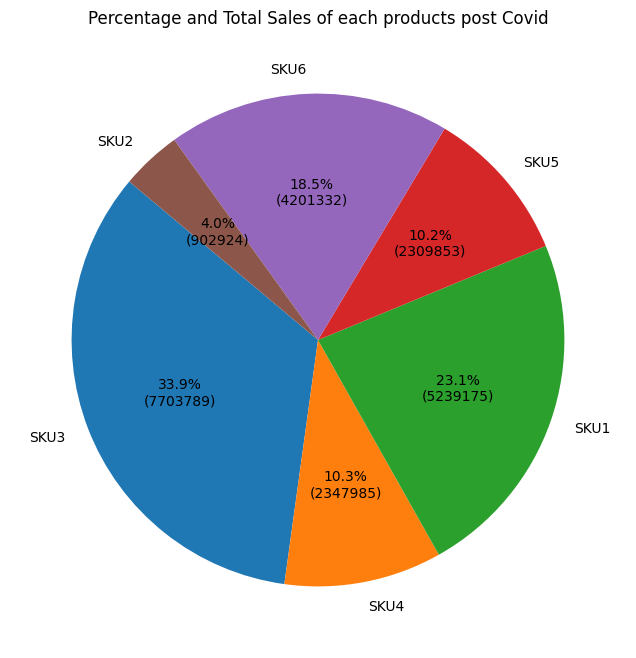

In [168]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

after_date = after_date.withColumn('Sales', F.when(F.col('Sales').isNull(), 0).otherwise(F.col('Sales')))

product_sales2 = after_date.groupBy('Product').agg(F.sum('Sales').alias('TotalSales'))

product_sales_pd = product_sales2.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(product_sales_pd['TotalSales'], labels=product_sales_pd['Product'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(product_sales_pd['TotalSales']) / 100), startangle=140)

plt.title('Percentage and Total Sales of each products post Covid')

plt.show()


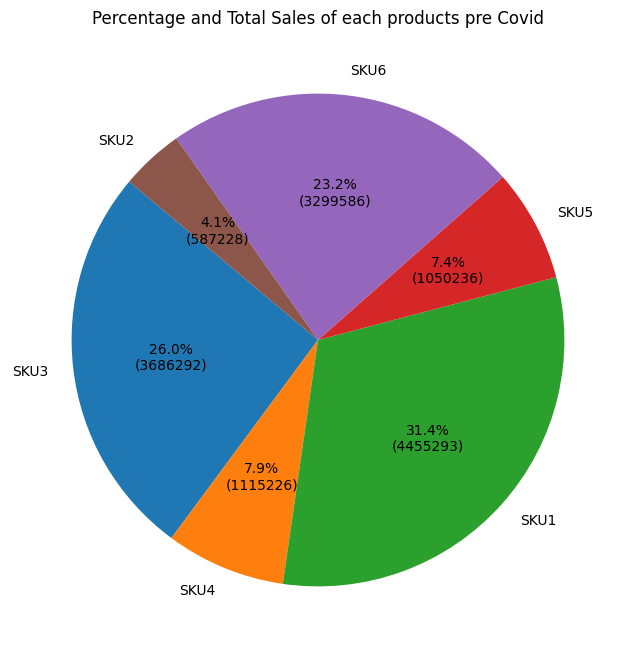

In [169]:
from pyspark.sql import functions as F

before_date = before_date.withColumn('Sales', F.when(F.col('Sales').isNull(), 0).otherwise(F.col('Sales')))

product_sales = before_date.groupBy('Product').agg(F.sum('Sales').alias('TotalSales'))

product_sales_pd = product_sales.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(product_sales_pd['TotalSales'], labels=product_sales_pd['Product'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(product_sales_pd['TotalSales']) / 100), startangle=140)

plt.title('Percentage and Total Sales of each products pre Covid')

plt.show()

**Observation**  
In terms of the percantages of the products to sales, there are no very big difference between pre covid and post covid.  
In general both before Covid and after Covid, SKU3 is the most popular products. SKU1 is the secondest popular. And SKU6 is the 3rd.   
SKU4 and SKU5 are kinds of same sales amounts. And SKU2 is the least popular products.  

In [170]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum

spark = SparkSession.builder.appName("SalesComparison").getOrCreate()

before_covid_sales = before_date.groupBy("Product").agg(sum("Sales").alias("Sales_before_covid"))
after_covid_sales = after_date.groupBy("Product").agg(sum("Sales").alias("Sales_after_covid"))

sales_comparison_table = before_covid_sales.join(after_covid_sales, "Product", "outer")

sales_comparison_table = sales_comparison_table.withColumn("Sales_change", ((col("Sales_after_covid") - col("Sales_before_covid")) / col("Sales_before_covid")) * 100)

sales_comparison_table.show()

+-------+------------------+-----------------+------------------+
|Product|Sales_before_covid|Sales_after_covid|      Sales_change|
+-------+------------------+-----------------+------------------+
|   SKU1|         4455293.0|          5239175|17.594398393102317|
|   SKU2|          587228.0|           902924| 53.76037927346788|
|   SKU3|         3686292.0|          7703789|108.98477385947723|
|   SKU4|         1115226.0|          2347985|110.53894008927338|
|   SKU5|         1050236.0|          2309853|119.93656663835557|
|   SKU6|         3299586.0|          4201332| 27.32906491905348|
+-------+------------------+-----------------+------------------+



**Observation**  
Sales of all of products significantly reduced between 70% and 80% minus after Covid compared to before Covid.  

In [171]:
from pyspark.sql.types import IntegerType

df_hist = df.withColumn("Sales", col("Sales").cast(IntegerType()))

hist_data = df_hist.select("Sales").rdd.flatMap(lambda x: x).histogram(10)

print(hist_data)

([0.0, 28832.2, 57664.4, 86496.6, 115328.8, 144161.0, 172993.2, 201825.4, 230657.6, 259489.80000000002, 288322], [768, 287, 109, 25, 13, 4, 8, 4, 5, 1])


In [172]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

df = df.withColumn("Sales", col("Sales").cast(DoubleType()))

df = df.withColumn("Google_Mobility", col("Google_Mobility").cast(DoubleType()))

correlation = df.corr("Sales", "Google_Mobility")

print(correlation)

0.05691633839446528


In [173]:
df_corr1 = before_date.withColumn("Sales", col("Sales").cast(DoubleType()))

df_corr1 = df_corr1.withColumn("Google_Mobility", col("Google_Mobility").cast(DoubleType()))

correlation = df_corr1.corr("Sales", "Google_Mobility")

print(correlation)

0.090287941511131


In [174]:
df_corr2 = after_date.withColumn("Sales", col("Sales").cast(DoubleType()))

df_corr2 = df_corr2.withColumn("Google_Mobility", col("Google_Mobility").cast(DoubleType()))

correlation = df_corr2.corr("Sales", "Google_Mobility")

print(correlation)

0.06326938251423628


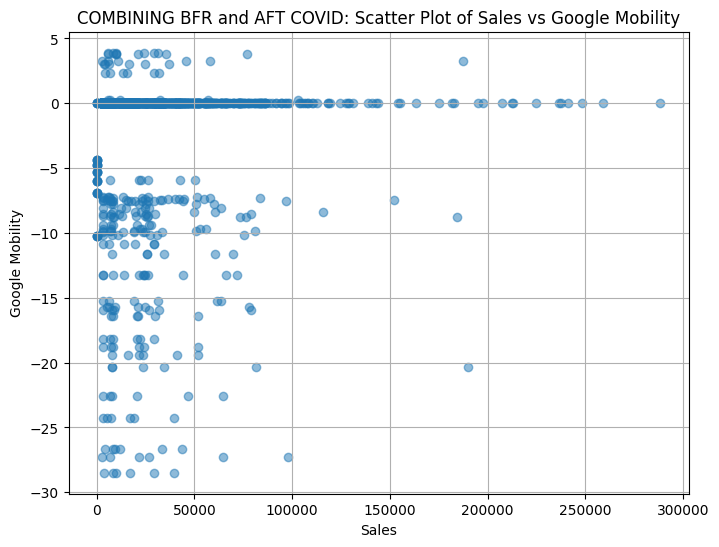

In [175]:
import pandas as pd
import matplotlib.pyplot as plt

pandas_df = df.toPandas()

sales_column = pandas_df["Sales"]
google_mobility_column = pandas_df["Google_Mobility"]

plt.figure(figsize=(8, 6))
plt.scatter(sales_column, google_mobility_column, alpha=0.5)
plt.title("COMBINING BFR and AFT COVID: Scatter Plot of Sales vs Google Mobility")
plt.xlabel("Sales")
plt.ylabel("Google Mobility")
plt.grid(True)

plt.show()

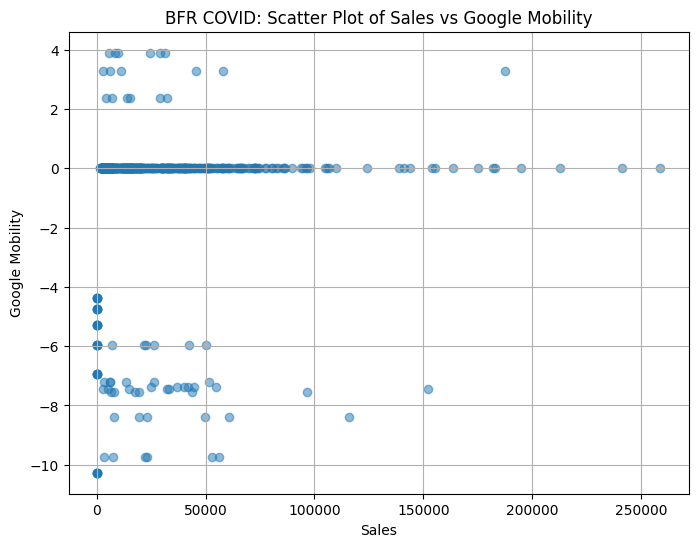

In [176]:
pandas_df1 = before_date.toPandas()

sales_column = pandas_df1["Sales"]
google_mobility_column = pandas_df1["Google_Mobility"]

plt.figure(figsize=(8, 6))
plt.scatter(sales_column, google_mobility_column, alpha=0.5)
plt.title("BFR COVID: Scatter Plot of Sales vs Google Mobility")
plt.xlabel("Sales")
plt.ylabel("Google Mobility")
plt.grid(True)

plt.show()

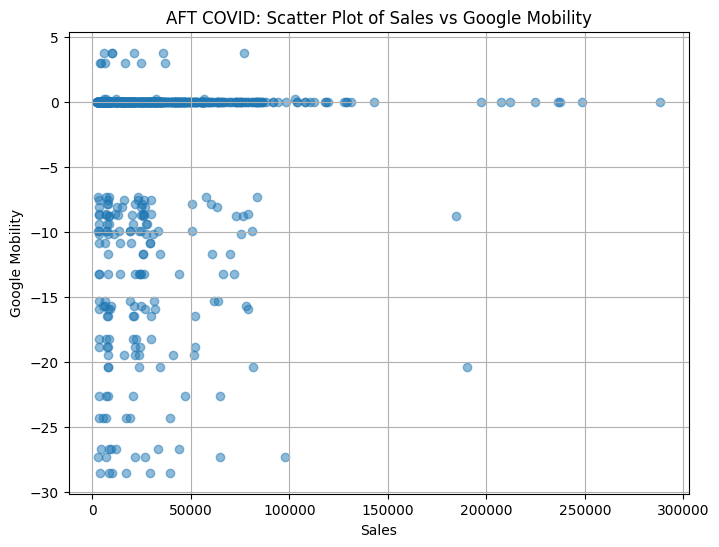

In [177]:
pandas_df2 = after_date.toPandas()

pandas_df2 = pandas_df2.sort_values(by="Google_Mobility")

sales_column = pandas_df2["Sales"]
google_mobility_column = pandas_df2["Google_Mobility"]

plt.figure(figsize=(8, 6))
plt.scatter(sales_column, google_mobility_column, alpha=0.5)
plt.title("AFT COVID: Scatter Plot of Sales vs Google Mobility")
plt.xlabel("Sales")
plt.ylabel("Google Mobility")
plt.grid(True)

plt.show()

In [178]:
cross_tab = df.crosstab("Product", "Covid_flag")
print(cross_tab)

DataFrame[Product_Covid_flag: string, 0: bigint, 1: bigint]


**Recommendation**  
Since the sales of the bebarage company is too differnt between before Covid and after Covid, we recommend to use the data after Covid to build model and demostrate accuracy for Q3-Q4 of 2020.
If we include the data with before Covid, that is totaly different circumstance that will provides inaccurate prediction.
However, in term of exploring more opportunities to be able to use multiplie methods, we also recommend to use entire of dataset. This is because only EDA can't fugure it out the accurate insights.  

#Multivariate Time Series Modeling using LSTM (Long Short-Term Memory)

In [179]:
! pip install tensorflow

In [180]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [181]:
df2_2.shape

(117, 9)

In [182]:
final_df2_input = df2_2[['Sales', 'Price_Discount', 'In-Store_Promo', 'Catalogue_Promo', 'Store_End_Promo', 'Google_Mobility', 'Covid_Flag', 'Holiday_Flag']]

In [183]:
print(final_df2_input)

     Sales  Price_Discount  In-Store_Promo  Catalogue_Promo  Store_End_Promo  \
2     2753               0               0                0                0   
3     3062               0               1                0                0   
5     3124               0               0                1                0   
7     3226               0               1                0                0   
9     3084               0               0                0                0   
..     ...             ...             ...              ...              ...   
199      0               0               1                0                0   
200      0               0               0                0                0   
201      0               0               0                0                0   
202      0               0               0                0                0   
203      0               0               0                0                0   

     Google_Mobility  Covid_Flag  Holid

In [184]:
final_df2_input.describe()

,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag
count,117.000000,117.0,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,2766.068376,0.0,0.316239,0.179487,0.059829,-3.153846,0.273504,0.059829
std,787.751840,0.0,0.467008,0.385410,0.238190,6.562190,0.447675,0.238190
min,0.000000,0.0,0.000000,0.000000,0.000000,-28.000000,0.000000,0.000000
25%,2580.000000,0.0,0.000000,0.000000,0.000000,-4.000000,0.000000,0.000000
50%,2907.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3226.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,4258.000000,0.0,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000


In [185]:
final_df2_input = np.array(final_df2_input)
print(final_df2_input)

[[2753    0    0    0    0    0    0    0]
 [3062    0    1    0    0    0    0    0]
 [3124    0    0    1    0    0    0    0]
 [3226    0    1    0    0    0    0    0]
 [3084    0    0    0    0    0    0    1]
 [2463    0    1    0    0    0    0    0]
 [3390    0    0    0    0    0    0    0]
 [3450    0    0    1    0    0    0    0]
 [3081    0    0    1    1    0    0    0]
 [3232    0    0    1    0    0    0    0]
 [3232    0    0    0    0    0    0    0]
 [2560    0    1    0    0    0    0    0]
 [2990    0    0    1    0    0    0    0]
 [3071    0    0    0    0    0    0    0]
 [3098    0    0    0    0    0    0    0]
 [3078    0    1    0    0    0    0    0]
 [2626    0    0    0    0    0    0    0]
 [2617    0    0    0    0    0    0    0]
 [2572    0    1    0    0    0    0    0]
 [2242    0    1    0    0    0    0    0]
 [2523    0    1    0    0    0    0    0]
 [2636    0    1    0    0    0    0    0]
 [2521    0    0    0    0    0    0    0]
 [2380    0

In [186]:
features2 = final_df2_input
target2 = final_df2_input[:, 0]

In [187]:
TimeseriesGenerator(features2, target2, length=2, sampling_rate=1, batch_size=1)[0]

(array([[[2753,    0,    0,    0,    0,    0,    0,    0],
         [3062,    0,    1,    0,    0,    0,    0,    0]]]),
 array([3124]))

In [188]:
x_train, x_test, y_train, y_test = train_test_split(features2, target2, test_size=0.20, random_state=123, shuffle=False)

In [189]:
x_train.shape

(93, 8)

In [190]:
x_test.shape

(24, 8)

In [191]:
y_train.shape

(93,)

In [192]:
y_test.shape

(24,)

In [193]:
y_test

array([3298, 3411, 3424, 3416, 3181, 3339, 3425, 3279, 3267, 3154, 3076,
       3210, 3170, 3081, 3322, 3160, 3062, 3464,    0,    0,    0,    0,
          0,    0])

In [194]:
win_length=6
batch_size=32
num_features=8
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [195]:
train_generator[0]

(array([[[2753,    0,    0, ...,    0,    0,    0],
         [3062,    0,    1, ...,    0,    0,    0],
         [3124,    0,    0, ...,    0,    0,    0],
         [3226,    0,    1, ...,    0,    0,    0],
         [3084,    0,    0, ...,    0,    0,    1],
         [2463,    0,    1, ...,    0,    0,    0]],
 
        [[3062,    0,    1, ...,    0,    0,    0],
         [3124,    0,    0, ...,    0,    0,    0],
         [3226,    0,    1, ...,    0,    0,    0],
         [3084,    0,    0, ...,    0,    0,    1],
         [2463,    0,    1, ...,    0,    0,    0],
         [3390,    0,    0, ...,    0,    0,    0]],
 
        [[3124,    0,    0, ...,    0,    0,    0],
         [3226,    0,    1, ...,    0,    0,    0],
         [3084,    0,    0, ...,    0,    0,    1],
         [2463,    0,    1, ...,    0,    0,    0],
         [3390,    0,    0, ...,    0,    0,    0],
         [3450,    0,    0, ...,    0,    0,    0]],
 
        ...,
 
        [[2583,    0,    0, ...,    0,  

In [196]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [197]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 128)            70144     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 6, 128)            0         
                                                                 
 dropout (Dropout)           (None, 6, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [198]:
features2 = features2.astype(float)
target2 = target2.astype(float)

In [199]:
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_generator, epochs=100,
                              validation_data=test_generator)
                              #callbacks=[early_stopping])

Epoch 1/100


<ipython-input-199-7aea92139db7>:5: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



3/3 [==============================] - 10s 1s/step - loss: 8303338.5000 - mean_absolute_error: 2840.9343 - val_loss: 6930626.5000 - val_mean_absolute_error: 2148.0381
Epoch 2/100
3/3 [==============================] - 0s 51ms/step - loss: 8298822.5000 - mean_absolute_error: 2840.1438 - val_loss: 6926272.0000 - val_mean_absolute_error: 2147.6370
Epoch 3/100
3/3 [==============================] - 0s 55ms/step - loss: 8292334.5000 - mean_absolute_error: 2838.9973 - val_loss: 6919820.0000 - val_mean_absolute_error: 2147.0820
Epoch 4/100
3/3 [==============================] - 0s 57ms/step - loss: 8282645.5000 - mean_absolute_error: 2837.2705 - val_loss: 6912423.0000 - val_mean_absolute_error: 2146.5281
Epoch 5/100
3/3 [==============================] - 0s 57ms/step - loss: 8274136.5000 - mean_absolute_error: 2835.8054 - val_loss: 6906155.5000 - val_mean_absolute_error: 2146.1086
Epoch 6/100
3/3 [==============================] - 0s 54ms/step - loss: 8265665.5000 - mean_absolute_error: 2834.

In [200]:
model.evaluate_generator(test_generator, verbose=0)

<ipython-input-200-a68ec1088d46>:1: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



[6807100.5, 2138.440673828125]

In [201]:
predictions = model.predict_generator(test_generator)

<ipython-input-201-9068eb02ed61>:1: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



In [202]:
predictions.shape[0]

18

In [203]:
predictions

array([[29.677633],
       [29.677633],
       [29.677633],
       [29.677633],
       [29.677633],
       [29.677633],
       [29.677633],
       [29.677633],
       [29.677633],
       [29.677633],
       [29.677633],
       [29.677633],
       [29.677633],
       [29.67753 ],
       [29.677505],
       [29.677479],
       [29.677435],
       [29.677027]], dtype=float32)

In [204]:
y_test = np.array(y_test)
print(y_test)

[3298 3411 3424 3416 3181 3339 3425 3279 3267 3154 3076 3210 3170 3081
 3322 3160 3062 3464    0    0    0    0    0    0]


In [205]:
x_test = np.array(x_test)
print(x_test)

[[3298    0    0    0    0  -16    1    0]
 [3411    0    0    0    0  -15    1    0]
 [3424    0    0    0    0  -13    1    0]
 [3416    0    0    0    0  -11    1    0]
 [3181    0    0    0    0  -10    1    0]
 [3339    0    0    0    0   -9    1    0]
 [3425    0    0    0    0   -9    1    0]
 [3279    0    0    0    0   -8    1    0]
 [3267    0    0    0    0   -8    1    0]
 [3154    0    1    0    0   -9    1    0]
 [3076    0    1    0    0  -10    1    0]
 [3210    0    1    0    0  -13    1    0]
 [3170    0    1    0    0  -19    1    0]
 [3081    0    0    0    0   -7    1    0]
 [3322    0    1    0    0  -10    1    0]
 [3160    0    0    1    1  -10    1    0]
 [3062    0    1    0    0   -7    1    0]
 [3464    0    1    0    0   -7    1    0]
 [   0    0    1    0    0   -6    1    0]
 [   0    0    1    0    0   -5    1    0]
 [   0    0    0    0    0   -4    1    0]
 [   0    0    0    0    0   -5    1    0]
 [   0    0    0    0    0  -10    1    1]
 [   0    0

In [206]:
#x_test.iloc[:, 0:][win_length:]
x_test[:, 0:][win_length:]
#x_test[:, 0:]

array([[3425,    0,    0,    0,    0,   -9,    1,    0],
       [3279,    0,    0,    0,    0,   -8,    1,    0],
       [3267,    0,    0,    0,    0,   -8,    1,    0],
       [3154,    0,    1,    0,    0,   -9,    1,    0],
       [3076,    0,    1,    0,    0,  -10,    1,    0],
       [3210,    0,    1,    0,    0,  -13,    1,    0],
       [3170,    0,    1,    0,    0,  -19,    1,    0],
       [3081,    0,    0,    0,    0,   -7,    1,    0],
       [3322,    0,    1,    0,    0,  -10,    1,    0],
       [3160,    0,    0,    1,    1,  -10,    1,    0],
       [3062,    0,    1,    0,    0,   -7,    1,    0],
       [3464,    0,    1,    0,    0,   -7,    1,    0],
       [   0,    0,    1,    0,    0,   -6,    1,    0],
       [   0,    0,    1,    0,    0,   -5,    1,    0],
       [   0,    0,    0,    0,    0,   -4,    1,    0],
       [   0,    0,    0,    0,    0,   -5,    1,    0],
       [   0,    0,    0,    0,    0,  -10,    1,    1],
       [   0,    0,    0,    0,

In [207]:
df_pred =pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,0:][win_length:])],axis=1)

In [208]:
df_pred

,0,0,1,2,3,4,5,6,7
0,29.677633,3425,0,0,0,0,-9,1,0
1,29.677633,3279,0,0,0,0,-8,1,0
2,29.677633,3267,0,0,0,0,-8,1,0
3,29.677633,3154,0,1,0,0,-9,1,0
4,29.677633,3076,0,1,0,0,-10,1,0
5,29.677633,3210,0,1,0,0,-13,1,0
6,29.677633,3170,0,1,0,0,-19,1,0
7,29.677633,3081,0,0,0,0,-7,1,0
8,29.677633,3322,0,1,0,0,-10,1,0
9,29.677633,3160,0,0,1,1,-10,1,0


In [209]:
df_pred

,0,0,1,2,3,4,5,6,7
0,29.677633,3425,0,0,0,0,-9,1,0
1,29.677633,3279,0,0,0,0,-8,1,0
2,29.677633,3267,0,0,0,0,-8,1,0
3,29.677633,3154,0,1,0,0,-9,1,0
4,29.677633,3076,0,1,0,0,-10,1,0
5,29.677633,3210,0,1,0,0,-13,1,0
6,29.677633,3170,0,1,0,0,-19,1,0
7,29.677633,3081,0,0,0,0,-7,1,0
8,29.677633,3322,0,1,0,0,-10,1,0
9,29.677633,3160,0,0,1,1,-10,1,0


In [210]:
from sklearn.preprocessing import StandardScaler

In [211]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

In [212]:
rev_trans = scaler.inverse_transform(df_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



In [213]:
rev_trans

array([[ 2.96818755e+01,  5.21715258e+06,  0.00000000e+00,
         5.00000000e-01,  5.55555556e-02,  5.55555556e-02,
        -3.85888704e+01,  2.00000000e+00,  5.55555556e-02],
       [ 2.96818755e+01,  4.99484875e+06,  0.00000000e+00,
         5.00000000e-01,  5.55555556e-02,  5.55555556e-02,
        -3.52518354e+01,  2.00000000e+00,  5.55555556e-02],
       [ 2.96818755e+01,  4.97657720e+06,  0.00000000e+00,
         5.00000000e-01,  5.55555556e-02,  5.55555556e-02,
        -3.52518354e+01,  2.00000000e+00,  5.55555556e-02],
       [ 2.96818755e+01,  4.80452013e+06,  0.00000000e+00,
         1.00000000e+00,  5.55555556e-02,  5.55555556e-02,
        -3.85888704e+01,  2.00000000e+00,  5.55555556e-02],
       [ 2.96818755e+01,  4.68575506e+06,  0.00000000e+00,
         1.00000000e+00,  5.55555556e-02,  5.55555556e-02,
        -4.19259054e+01,  2.00000000e+00,  5.55555556e-02],
       [ 2.96818755e+01,  4.88978735e+06,  0.00000000e+00,
         1.00000000e+00,  5.55555556e-02,  5.555555

In [214]:
final_df2_result=final_df2_input[predictions.shape[0]*-1:]

In [215]:
row_count = final_df2_result.shape[0]
print("row:", row_count)

row: 18


In [216]:
final_df2_result

array([[3425,    0,    0,    0,    0,   -9,    1,    0],
       [3279,    0,    0,    0,    0,   -8,    1,    0],
       [3267,    0,    0,    0,    0,   -8,    1,    0],
       [3154,    0,    1,    0,    0,   -9,    1,    0],
       [3076,    0,    1,    0,    0,  -10,    1,    0],
       [3210,    0,    1,    0,    0,  -13,    1,    0],
       [3170,    0,    1,    0,    0,  -19,    1,    0],
       [3081,    0,    0,    0,    0,   -7,    1,    0],
       [3322,    0,    1,    0,    0,  -10,    1,    0],
       [3160,    0,    0,    1,    1,  -10,    1,    0],
       [3062,    0,    1,    0,    0,   -7,    1,    0],
       [3464,    0,    1,    0,    0,   -7,    1,    0],
       [   0,    0,    1,    0,    0,   -6,    1,    0],
       [   0,    0,    1,    0,    0,   -5,    1,    0],
       [   0,    0,    0,    0,    0,   -4,    1,    0],
       [   0,    0,    0,    0,    0,   -5,    1,    0],
       [   0,    0,    0,    0,    0,  -10,    1,    1],
       [   0,    0,    0,    0,

In [217]:
final_df2_result = pd.DataFrame(final_df2_result)
print(final_df2_result)

       0  1  2  3  4   5  6  7
0   3425  0  0  0  0  -9  1  0
1   3279  0  0  0  0  -8  1  0
2   3267  0  0  0  0  -8  1  0
3   3154  0  1  0  0  -9  1  0
4   3076  0  1  0  0 -10  1  0
5   3210  0  1  0  0 -13  1  0
6   3170  0  1  0  0 -19  1  0
7   3081  0  0  0  0  -7  1  0
8   3322  0  1  0  0 -10  1  0
9   3160  0  0  1  1 -10  1  0
10  3062  0  1  0  0  -7  1  0
11  3464  0  1  0  0  -7  1  0
12     0  0  1  0  0  -6  1  0
13     0  0  1  0  0  -5  1  0
14     0  0  0  0  0  -4  1  0
15     0  0  0  0  0  -5  1  0
16     0  0  0  0  0 -10  1  1
17     0  0  0  0  0  -7  1  0


In [218]:
final_df2_result['Sales_Pred'] = rev_trans[:, 0]

In [219]:
final_df2_result['Sales_Pred']

0     29.681876
1     29.681876
2     29.681876
3     29.681876
4     29.681876
5     29.681876
6     29.681876
7     29.681876
8     29.681876
9     29.681876
10    29.681876
11    29.681876
12    29.681876
13    29.681876
14    29.681875
15    29.681875
16    29.681875
17    29.681875
Name: Sales_Pred, dtype: float64

In [ ]:
#final_df2_result[['Sales', 'Sales_Pred']].plot()

#Multivariate Time Series Modeling using Prophet

In [220]:
!pip install prophet

In [221]:
! pip install fbprophet --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 721.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
ERROR: Could not build wheels for fbprophet, which is required to install pyproject.toml-based projects


In [222]:
! pip install tensorflow --upgrade

In [223]:
from prophet import Prophet

In [226]:
df2_propht =df2_2
df2_propht

,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag
2,2/19/2017,2753,0,0,0,0,0,0,0
3,2/26/2017,3062,0,1,0,0,0,0,0
5,3/12/2017,3124,0,0,1,0,0,0,0
7,3/26/2017,3226,0,1,0,0,0,0,0
9,4/9/2017,3084,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
199,11/29/2020,0,0,1,0,0,-5,1,0
200,12/6/2020,0,0,0,0,0,-4,1,0
201,12/13/2020,0,0,0,0,0,-5,1,0
202,12/20/2020,0,0,0,0,0,-10,1,1


In [227]:
df2_propht.shape

(117, 9)

In [228]:
df2_propht  = df2_propht.rename(columns={'Sales' : 'y', 'date': 'ds'})
df2_propht['y_orig'] = df2_propht['y']
df2_propht['y'] = np.log(df2_propht['y'])

model_new = Prophet()
model_new.add_regressor('Price Discount (%)')
model_new.add_regressor('In-Store Promo')
model_new.add_regressor('Catalogue Promo')
model_new.add_regressor('Store End Promo')
model_new.add_regressor('Google_Mobility')
model_new.add_regressor('Covid_Flag')
model_new.add_regressor('Holiday_Flag')


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log



In [234]:
cutoff_date = pd.to_datetime('2020-11-22')
df2_propht['ds'] = pd.to_datetime(df2_propht['ds'])
df2_propht.loc[df2_propht['ds'] >= cutoff_date, 'y'] = 0

In [235]:
df2_propht.shape

(117, 10)

In [236]:
train_df2 = df2_propht[:22]
test_df2 = df2_propht[22:]

In [237]:
train_df2.shape

(22, 10)

In [238]:
test_df2.shape

(95, 10)

In [239]:
for column in train_df2.columns:
    data_type = train_df2[column].dtype
    print(f'Column "{column}" has data type: {data_type}')

if 'DateColumn1' in train_df2.columns and 'DateColumn2' in train_df2.columns:
    print('Both DateColumn1 and DateColumn2 are present.')

else:
    print('Timestamp columns are not present.')

Column "ds" has data type: datetime64[ns]
Column "y" has data type: float64
Column "Price_Discount" has data type: int64
Column "In-Store_Promo" has data type: int64
Column "Catalogue_Promo" has data type: int64
Column "Store_End_Promo" has data type: int64
Column "Google_Mobility" has data type: int64
Column "Covid_Flag" has data type: int64
Column "Holiday_Flag" has data type: int64
Column "y_orig" has data type: int64
Timestamp columns are not present.


In [240]:
train_df2['ds'] = pd.to_datetime(train_df2['ds'])

data_type = train_df2['ds'].dtype
print(f"'ds' column has been converted to data type: {data_type}")

'ds' column has been converted to data type: datetime64[ns]


<ipython-input-240-3b78fc729385>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [241]:
np.array(train_df2['ds'], dtype=np.datetime64)

array(['2017-02-19T00:00:00.000000000', '2017-02-26T00:00:00.000000000',
       '2017-03-12T00:00:00.000000000', '2017-03-26T00:00:00.000000000',
       '2017-04-09T00:00:00.000000000', '2017-04-16T00:00:00.000000000',
       '2017-05-07T00:00:00.000000000', '2017-05-14T00:00:00.000000000',
       '2017-06-04T00:00:00.000000000', '2017-06-18T00:00:00.000000000',
       '2017-07-02T00:00:00.000000000', '2017-07-09T00:00:00.000000000',
       '2017-07-23T00:00:00.000000000', '2017-08-06T00:00:00.000000000',
       '2017-08-13T00:00:00.000000000', '2017-08-20T00:00:00.000000000',
       '2017-09-03T00:00:00.000000000', '2017-09-10T00:00:00.000000000',
       '2017-09-17T00:00:00.000000000', '2017-10-01T00:00:00.000000000',
       '2017-10-15T00:00:00.000000000', '2017-11-05T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [ ]:
#train_df2 = train_df2.dropna()

In [242]:
train_df2.to_csv('train_df2.csv', index=False)

In [243]:
model = Prophet(weekly_seasonality=True)

In [244]:
train_df2['ds'] = pd.to_datetime(train_df2['ds'])

model = Prophet()

model.fit(train_df2)

future_data2 = model.make_future_dataframe(periods=204, freq='W')

forecast2 = model.predict(future_data2)

<ipython-input-244-445800d933ad>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3fy1bwlg/6voowihu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3fy1bwlg/oki_an81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/proph

In [245]:
future_data2.head()

,ds
0,2017-02-19
1,2017-02-26
2,2017-03-12
3,2017-03-26
4,2017-04-09


In [246]:
train_df2 = train_df2.append(test_df2)
train_df2 = train_df2.rename(columns = {'Sales': 'y', 'date' : 'ds'})
feature_data2 = train_df2[['ds', 'Price_Discount', 'In-Store_Promo', 'Catalogue_Promo', 'Store_End_Promo', 'Google_Mobility', 'Covid_Flag', 'Holiday_Flag']]

AttributeError: ignored

In [ ]:
feature_data2.head()

In [ ]:
print(forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

In [ ]:
model.plot(forecast2)

In [ ]:
model.plot_components(forecast2)

In [ ]:
forecast_data_ori = forecast2
forecast_data_ori['yhat'] = np.exp(forecast_data_ori['yhat'])
forecast_data_ori['yhat_lower'] = np.exp(forecast_data_ori['yhat_lower'])
forecast_data_ori['yhat_upper'] = np.exp(forecast_data_ori['yhat_upper'])

model.plot(forecast_data_ori)

In [ ]:
df2_propht['y_log'] = df2_propht['y']
df2_propht['y'] = df2_propht['y_orig']

In [ ]:
final_df2 = pd.DataFrame(forecast_data_ori)
import plotly.graph_objs as go
import plotly.offline as py

actual_chart = go.Scatter(y=df2_propht['y_orig'], name = 'Actual')
predict_chart = go.Scatter(y=final_df2['yhat'], name = 'Predicted')
predict_chart_upper = go.Scatter(y=final_df2['yhat_upper'], name = 'Predicted Upper')
predict_chart_lower = go.Scatter(y=final_df2['yhat_lower'], name = 'Predicted Lower')
py.plot([actual_chart, predict_chart, predict_chart_upper, predict_chart_lower])

'temp-plot.html'

#Multivariate Time Series Modeling using VAR (Vector Autoregression)  

-This data is not stational. It is better to be stational but it was not able to adjust it with any method. Applyong VAR, we need to have stational data. That means we can't use it for this data.  

#Multivariate Time Series Modeling using XGBoost  

In [247]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [248]:
df2_2

,date,Sales,Price_Discount,In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,Holiday_Flag
2,2/19/2017,2753,0,0,0,0,0,0,0
3,2/26/2017,3062,0,1,0,0,0,0,0
5,3/12/2017,3124,0,0,1,0,0,0,0
7,3/26/2017,3226,0,1,0,0,0,0,0
9,4/9/2017,3084,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
199,11/29/2020,0,0,1,0,0,-5,1,0
200,12/6/2020,0,0,0,0,0,-4,1,0
201,12/13/2020,0,0,0,0,0,-5,1,0
202,12/20/2020,0,0,0,0,0,-10,1,1


In [249]:
import matplotlib.pyplot as plt

In [251]:
df2_input = df2_2[['Sales', 'Price_Discount', 'In-Store_Promo', 'Catalogue_Promo', 'Store_End_Promo', 'Google_Mobility', 'Covid_Flag', 'Holiday_Flag']]

In [252]:
df2_input = df2_input.to_numpy()

print(df2_input)

[[2753    0    0    0    0    0    0    0]
 [3062    0    1    0    0    0    0    0]
 [3124    0    0    1    0    0    0    0]
 [3226    0    1    0    0    0    0    0]
 [3084    0    0    0    0    0    0    1]
 [2463    0    1    0    0    0    0    0]
 [3390    0    0    0    0    0    0    0]
 [3450    0    0    1    0    0    0    0]
 [3081    0    0    1    1    0    0    0]
 [3232    0    0    1    0    0    0    0]
 [3232    0    0    0    0    0    0    0]
 [2560    0    1    0    0    0    0    0]
 [2990    0    0    1    0    0    0    0]
 [3071    0    0    0    0    0    0    0]
 [3098    0    0    0    0    0    0    0]
 [3078    0    1    0    0    0    0    0]
 [2626    0    0    0    0    0    0    0]
 [2617    0    0    0    0    0    0    0]
 [2572    0    1    0    0    0    0    0]
 [2242    0    1    0    0    0    0    0]
 [2523    0    1    0    0    0    0    0]
 [2636    0    1    0    0    0    0    0]
 [2521    0    0    0    0    0    0    0]
 [2380    0

In [253]:
features2 = df2_input
target2 = df2_input[:, 0]

In [254]:
#X_pandas = X.toPandas()
#y_pandas = y.toPandas()

X_train, X_test, y_train, y_test = train_test_split(features2, target2, test_size=0.2, random_state=42)

In [255]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, random_state=42)

In [256]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [257]:
y_pred = model.predict(X_test)

In [258]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 122.67170499272704


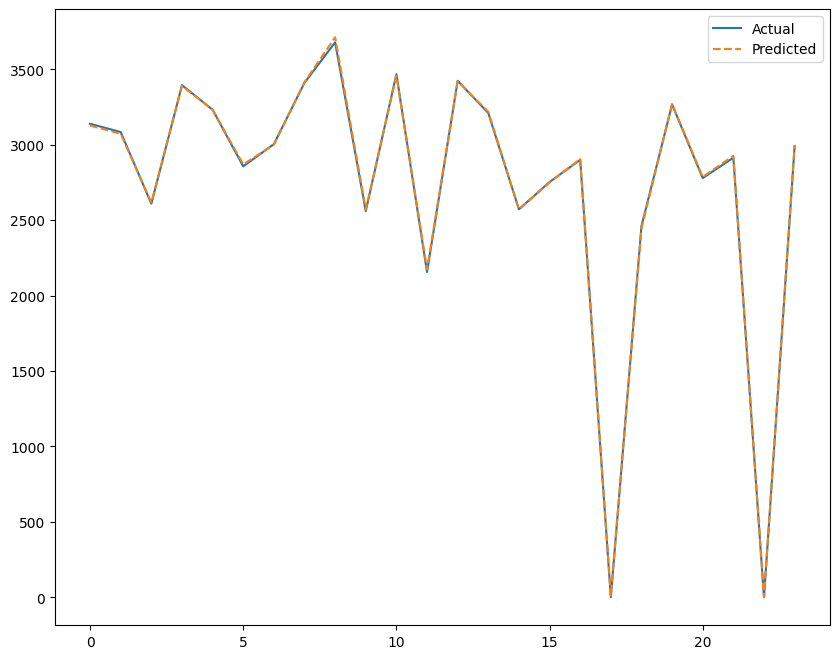

In [259]:
plt.plot(y_test, label='Actual', linestyle='-')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.show()

#Multivariate Time Series Modeling using SVM (Support Vector Machine)

In [ ]:
! pip install pmdarima

In [ ]:
import pmdarima as pm
model2 = pm.auto_arima(final_df2['Sales'],
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)

In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(train['Sales'], trace=True,
suppress_warnings=True)

In [ ]:
train=df1.iloc[:-30]
test=df1.iloc[-30:]
train.head()


In [ ]:

test.head()

In [ ]:
train['Sales'] = pd.to_numeric(train['Sales'])
train.dtypes

In [ ]:
import statsmodels.api as sm


In [ ]:
np.asarray(train)

In [ ]:
test['Sales'] = pd.to_numeric(test['Sales'])

In [ ]:
#from statsmodels.tsa.arima_model import ARIMA
model=sm.tsa.arima.ARIMA(train['Sales'],order=(2,0,0))
model=model.fit()
model.summary()

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Sales'].plot(legend=True)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Sales'].mean()
rmse=sqrt(mean_squared_error(pred,test['Sales']))
print(rmse)


In [ ]:
pandas_df.head()